
# Recipe Classification/Regression Benchmark Report

This notebook benchmarks data augmentation methods and model architectures for recipe classification/regression, using robust pipelines and external evaluation. For each task and model, training, saving, evaluation, and visualization are performed and results are saved for reproducibility.


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import torch
from utils.data import load_csv, prepare_embeddings_data, train_val_test_split, LabelEncoderHelper, filter_meal_types
from utils.metrics import METRIC_REGISTRY
from utils.visualization import plot_confusion_matrix, plot_metric_history, plot_metric_csv, plot_regression_results
from pipelines_torch.models import MODEL_REGISTRY
from pipelines_torch.benchmark import BenchmarkRunner
from pipelines_torch.base import GeneralPipeline, GeneralPipelineSklearn, SimplePredictor
from data_augmentation.augmentations import AUGMENTATION_REGISTRY
from utils.visualization import plot_metrics_bar
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)
from utils.utils import save_model, save_metrics, load_model


## Difficulty Classification
### 1. Data Preprocessing
Load and preprocess data for difficulty classification.


In [5]:
df = load_csv('recipes_df.csv')
df = df.dropna(subset=['embeddings_class', 'difficult'])
# Map 'A challenge' to 'More effort'
df['difficult'] = df['difficult'].replace({'A challenge': 'More effort'})
print('Unique difficulty labels after mapping:', df['difficult'].unique())
X, y = prepare_embeddings_data(df, target_column='difficult', embedding_column='embeddings_class')
le = LabelEncoderHelper(); le.fit(y)
y_enc = le.transform(y)
if callable(getattr(le, 'classes', None)):
    classes_list = le.classes()
else:
    classes_list = le.classes
label_map = dict(zip(classes_list, le.transform(classes_list)))
print('Label mapping:', label_map)
X_train, X_val, _, y_train, y_val, _ = train_val_test_split(X, y_enc, val_size=0.2, test_size=0, stratify=y_enc)
input_dim = X_train.shape[1]
print(input_dim)
num_classes = len(np.unique(y_train))
model_names = [
    'mlp_classifier', 'deep_mlp_classifier', 'random_forest_classifier', 'xgboost_classifier', 'lightgbm_classifier'
]
model_configs = [
    {
        'name': name,
        'class': MODEL_REGISTRY[name],
        'params': {'input_dim': input_dim, 'num_classes': num_classes} if 'mlp' in name or 'transformer' in name else {}
    }
    for name in model_names
]
metrics = [METRIC_REGISTRY['f1'], METRIC_REGISTRY['recall'], METRIC_REGISTRY['precision'], METRIC_REGISTRY['accuracy']]
# Difficulty task: use mixup_smote instead of smote, remove random_oversampler
augmentation_names = [
    'none',  'borderline_smote', 'svm_smote', 'kmeans_smote'
]
augmentations = [AUGMENTATION_REGISTRY[name] for name in augmentation_names]
unique, counts = np.unique(y_val, return_counts=True)
class_dist = dict(zip(unique, counts))
print("Validation set class distribution:")
for cls, cnt in class_dist.items():
    print(f"Class {cls}: {cnt}")

Unique difficulty labels after mapping: ['Easy' 'More effort']
Label mapping: {np.str_('Easy'): np.int64(0), np.str_('More effort'): np.int64(1)}
768
Validation set class distribution:
Class 0: 266
Class 1: 27


### 2. Augmentation Benchmarking
Benchmark augmentations using the first model. Select the best augmentation.


#### Mlp_model

CSV already exists at results/difficulty_aug_bar_mlp.csv, skipping runner.


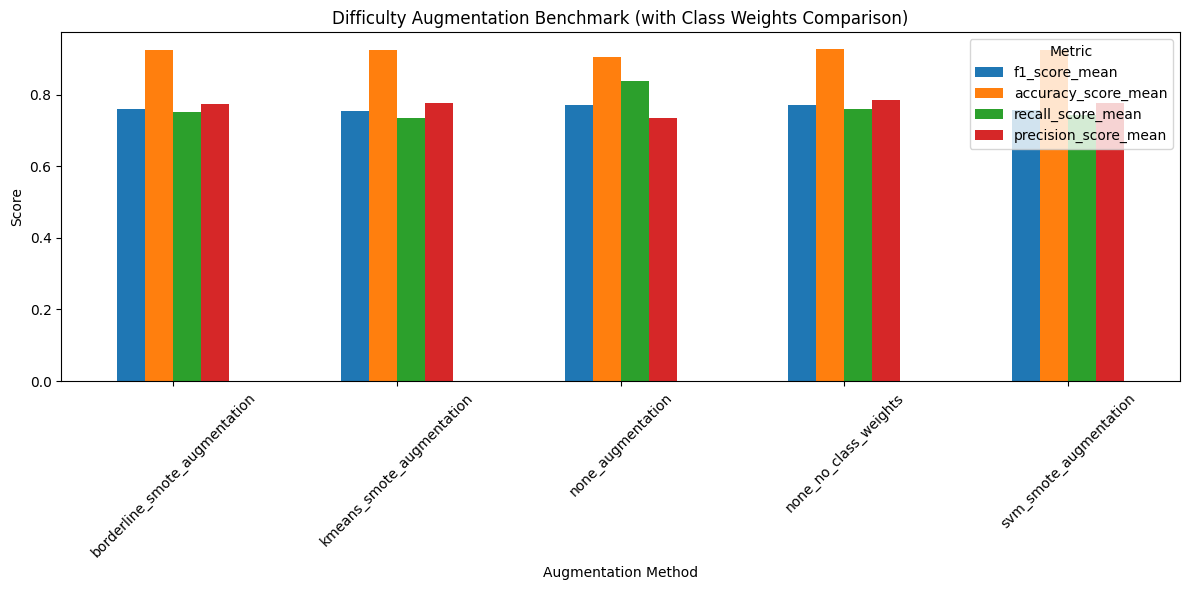


Best augmentation: borderline_smote


,f1_score_mean,accuracy_score_mean,recall_score_mean,precision_score_mean
augmentation,,,,
borderline_smote_augmentation,0.759991,0.924232,0.752462,0.773806
kmeans_smote_augmentation,0.752880,0.923549,0.735007,0.775874
none_augmentation,0.770074,0.906485,0.837037,0.735313
none_no_class_weights,0.771844,0.927645,0.760708,0.785156
svm_smote_augmentation,0.756756,0.924915,0.741990,0.777722


In [3]:
import os
csv_path = os.path.join(RESULTS_DIR, 'difficulty_aug_bar_mlp.csv')
if os.path.exists(csv_path):
    print(f"CSV already exists at {csv_path}, skipping runner.")
    pivot = pd.read_csv(csv_path, index_col=0)
else:
    runner = BenchmarkRunner(
        model_configs=[model_configs[0]],
        augmentations=augmentations,
        metrics=metrics,
        task_type='classification',
        device='cpu',
        epochs=150,
        batch_size=32,
        early_stopping=20,
        use_class_weights=True, 
        dropout=0.3,
        weight_decay=5e-4, 
        learning_rate=1e-4,
        path_start='difficulty', 
        max_factor=1.0  
    )
    # Use complete data - the pipeline will handle train/val splits internally
    aug_results = runner.run(X, y_enc)
    
    # Add comparison with use_class_weights=False for none augmentation
    print("\nRunning none augmentation with use_class_weights=False for comparison...")
    runner_no_weights = BenchmarkRunner(
        model_configs=[model_configs[0]],
        augmentations=[AUGMENTATION_REGISTRY['none']],  # Only none augmentation
        metrics=metrics,
        task_type='classification',
        device='cpu',
        epochs=150,
        batch_size=32,
        early_stopping=20,
        use_class_weights=False,  # This is the key difference
        dropout=0.3,
        weight_decay=5e-4, 
        learning_rate=1e-4,
        path_start='difficulty'
    )
    # Use complete data - the pipeline will handle train/val splits internally
    no_weights_results = runner_no_weights.run(X, y_enc)
    
    # Rename the augmentation to distinguish it
    no_weights_results['augmentation'] = 'none_no_class_weights'
    
    # Combine results
    combined_results = pd.concat([aug_results, no_weights_results], ignore_index=True)
    
    pivot = combined_results.pivot_table(index='augmentation', columns='metric', values='score')
    pivot.to_csv(csv_path)

# Keep only the relevant columns
pivot = pivot[['f1_score_mean', 'accuracy_score_mean', 'recall_score_mean', 'precision_score_mean']]
plot_metrics_bar(pivot, title='Difficulty Augmentation Benchmark (with Class Weights Comparison)')

# Normalize the four scores and select best augmentation by mean (excluding the no_class_weights comparison)
augmentations_to_compare = [idx for idx in pivot.index if not idx.endswith('_no_class_weights')]
pivot_for_selection = pivot.loc[augmentations_to_compare]

score_cols = ['f1_score_mean', 'accuracy_score_mean']
normed = pivot_for_selection[score_cols].copy()
normed = (normed - normed.min()) / (normed.max() - normed.min())
mean_score = normed.mean(axis=1)
best_aug_name = mean_score.idxmax()
best_aug_name = best_aug_name.replace('_augmentation', '')
if best_aug_name == '<lambda>':
    best_aug_name = 'mixup_smote'
best_augmentation = AUGMENTATION_REGISTRY[best_aug_name]
print(f'\nBest augmentation: {best_aug_name}')
pivot

Models:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model: mlp_classifier | Augmentation: none_augmentation
Starting 5-fold cross-validation with weight averaging ensemble
Starting 5-fold cross-validation with weight averaging ensemble...
Training fold 1/5
Epoch 1/150 - Train Loss: 0.5342, Val Loss: 0.3962
Epoch 2/150 - Train Loss: 0.3426, Val Loss: 0.2923
Epoch 3/150 - Train Loss: 0.3028, Val Loss: 0.2847
Epoch 4/150 - Train Loss: 0.2975, Val Loss: 0.2787
Epoch 5/150 - Train Loss: 0.2958, Val Loss: 0.2711
Epoch 6/150 - Train Loss: 0.2864, Val Loss: 0.2625
Epoch 7/150 - Train Loss: 0.2794, Val Loss: 0.2532
Epoch 8/150 - Train Loss: 0.2720, Val Loss: 0.2419
Epoch 9/150 - Train Loss: 0.2533, Val Loss: 0.2295
Epoch 10/150 - Train Loss: 0.2420, Val Loss: 0.2172
Epoch 11/150 - Train Loss: 0.2296, Val Loss: 0.2045
Epoch 12/150 - Train Loss: 0.2203, Val Loss: 0.1943
Epoch 13/150 - Train Loss: 0.2047, Val Loss: 0.1872
Epoch 14/150 - Train Loss: 0.2029, Val Loss: 0.1822, F1: 0.0741
Epoch 15/150 - Train Loss: 0.1980, Val Loss: 0.1777, F1

Epoch 147/150 - Train Loss: 0.0819, Val Loss: 0.1937, F1: 0.5532
Epoch 148/150 - Train Loss: 0.0692, Val Loss: 0.1803, F1: 0.6038
Epoch 149/150 - Train Loss: 0.0729, Val Loss: 0.1940, F1: 0.5333
Epoch 150/150 - Train Loss: 0.0720, Val Loss: 0.1845, F1: 0.5600
  Fold 5 f1_score: 0.7595

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7718 ± 0.0210

accuracy_score : 0.9276 ± 0.0079
precision_score: 0.7852 ± 0.0269
recall_score   : 0.7607 ± 0.0180


Creating ensemble model by averaging weights from 5 folds...
  Successfully averaged 8/8 parameters across 5 folds
✅ Ensemble model created successfully!
   Model now contains averaged weights from all cross-validation folds
   This preserves validation criteria while creating a robust ensemble


Running Model: mlp_classifier | Augmentation: borderline_smote_augmentation
Starting 5-fold cross-validation with weight averaging ensemble
Starting 5-fold cross-validation with weight averaging ensemble...
Training fold 1/5
Epoch 1/150 - Train Loss: 0.

Epoch 150/150 - Train Loss: 0.0166, Val Loss: 0.3338, F1: 0.6071
  Fold 5 f1_score: 0.7828

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7867 ± 0.0282

accuracy_score : 0.9304 ± 0.0080
precision_score: 0.7894 ± 0.0231
recall_score   : 0.7854 ± 0.0365


Creating ensemble model by averaging weights from 5 folds...
  Successfully averaged 8/8 parameters across 5 folds
✅ Ensemble model created successfully!
   Model now contains averaged weights from all cross-validation folds
   This preserves validation criteria while creating a robust ensemble


Running Model: mlp_classifier | Augmentation: svm_smote_augmentation
Starting 5-fold cross-validation with weight averaging ensemble
Starting 5-fold cross-validation with weight averaging ensemble...
Training fold 1/5
Epoch 1/150 - Train Loss: 0.6619, Val Loss: 0.5131
Epoch 2/150 - Train Loss: 0.5964, Val Loss: 0.4163, F1: 0.3750
Epoch 3/150 - Train Loss: 0.4934, Val Loss: 0.3544, F1: 0.5763
Epoch 4/150 - Train Loss: 0.3723, Val Loss: 0.2728, F

Epoch 149/150 - Train Loss: 0.0207, Val Loss: 0.3096, F1: 0.5769
Epoch 150/150 - Train Loss: 0.0240, Val Loss: 0.3021, F1: 0.5614
  Fold 5 f1_score: 0.7571

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7755 ± 0.0174

accuracy_score : 0.9263 ± 0.0080
precision_score: 0.7793 ± 0.0258
recall_score   : 0.7736 ± 0.0179


Creating ensemble model by averaging weights from 5 folds...
  Successfully averaged 8/8 parameters across 5 folds
✅ Ensemble model created successfully!
   Model now contains averaged weights from all cross-validation folds
   This preserves validation criteria while creating a robust ensemble


Running Model: mlp_classifier | Augmentation: kmeans_smote_augmentation
Starting 5-fold cross-validation with weight averaging ensemble
Starting 5-fold cross-validation with weight averaging ensemble...
Training fold 1/5
Epoch 1/150 - Train Loss: 0.6637, Val Loss: 0.5335
Epoch 2/150 - Train Loss: 0.6195, Val Loss: 0.4780, F1: 0.1935
Epoch 3/150 - Train Loss: 0.5411, Val Loss: 0.37

Models: 100%|██████████| 1/1 [03:54<00:00, 235.00s/it]

Epoch 150/150 - Train Loss: 0.0124, Val Loss: 0.3358, F1: 0.5385
  Fold 5 f1_score: 0.7468

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7589 ± 0.0161

accuracy_score : 0.9222 ± 0.0040
precision_score: 0.7657 ± 0.0119
recall_score   : 0.7547 ± 0.0282


Creating ensemble model by averaging weights from 5 folds...
  Successfully averaged 8/8 parameters across 5 folds
✅ Ensemble model created successfully!
   Model now contains averaged weights from all cross-validation folds
   This preserves validation criteria while creating a robust ensemble



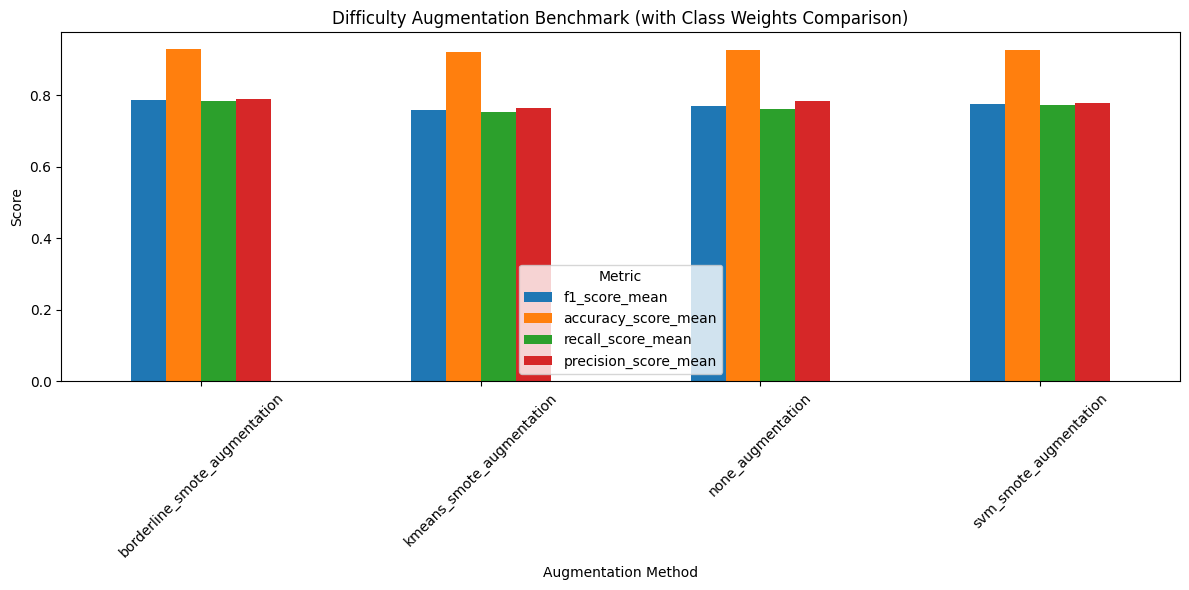


Best augmentation: borderline_smote


metric,f1_score_mean,accuracy_score_mean,recall_score_mean,precision_score_mean
augmentation,,,,
borderline_smote_augmentation,0.786734,0.930375,0.785361,0.789450
kmeans_smote_augmentation,0.758933,0.922184,0.754662,0.765688
none_augmentation,0.771844,0.927645,0.760708,0.785156
svm_smote_augmentation,0.775548,0.926280,0.773552,0.779254


In [5]:
import os
csv_path = os.path.join(RESULTS_DIR, 'difficulty2_aug_bar_mlp.csv')
if os.path.exists(csv_path):
    print(f"CSV already exists at {csv_path}, skipping runner.")
    pivot = pd.read_csv(csv_path, index_col=0)
else:
    runner = BenchmarkRunner(
        model_configs=[model_configs[0]],
        augmentations=augmentations,
        metrics=metrics,
        task_type='classification',
        device='cpu',
        epochs=150,
        batch_size=32,
        early_stopping=20,
        use_class_weights=False, 
        dropout=0.3,
        weight_decay=5e-4, 
        learning_rate=1e-4,
        path_start='difficulty2', 
        max_factor=1.5  
    )
    # Use complete data - the pipeline will handle train/val splits internally
    aug_results = runner.run(X, y_enc)
    
    # Combine results
    combined_results = pd.concat([aug_results], ignore_index=True)

    pivot = combined_results.pivot_table(index='augmentation', columns='metric', values='score')
    pivot.to_csv(csv_path)

# Keep only the relevant columns
pivot = pivot[['f1_score_mean', 'accuracy_score_mean', 'recall_score_mean', 'precision_score_mean']]
plot_metrics_bar(pivot, title='Difficulty Augmentation Benchmark (with Class Weights Comparison)')

# Normalize the four scores and select best augmentation by mean (excluding the no_class_weights comparison)
augmentations_to_compare = [idx for idx in pivot.index if not idx.endswith('_no_class_weights')]
pivot_for_selection = pivot.loc[augmentations_to_compare]

score_cols = ['f1_score_mean', 'accuracy_score_mean']
normed = pivot_for_selection[score_cols].copy()
normed = (normed - normed.min()) / (normed.max() - normed.min())
mean_score = normed.mean(axis=1)
best_aug_name = mean_score.idxmax()
best_aug_name = best_aug_name.replace('_augmentation', '')
if best_aug_name == '<lambda>':
    best_aug_name = 'mixup_smote'
best_augmentation = AUGMENTATION_REGISTRY[best_aug_name]
print(f'\nBest augmentation: {best_aug_name}')
pivot

#### Xgboost_model

Models:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Running Model: xgboost_classifier | Augmentation: none_augmentation
Class distribution: {np.int64(0): np.int64(1332), np.int64(1): np.int64(133)}
Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5
  Fold 1 f1_score: 0.7822
Training fold 2/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2 f1_score: 0.7802
Training fold 3/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3 f1_score: 0.7595
Training fold 4/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 4 f1_score: 0.7530
Training fold 5/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 5 f1_score: 0.8029

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7756 ± 0.0178

accuracy_score : 0.9290 ± 0.0055
precision_score: 0.7889 ± 0.0175
recall_score   : 0.7648 ± 0.0235


Training final model on full dataset...


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Final model trained successfully on full dataset!
Computed class weights: [0.54992492 5.5075188 ]

Running Model: xgboost_classifier | Augmentation: borderline_smote_augmentation
Class distribution: {np.int64(0): np.int64(1332), np.int64(1): np.int64(133)}
Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1 f1_score: 0.7960
Training fold 2/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2 f1_score: 0.7662
Training fold 3/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3 f1_score: 0.7595
Training fold 4/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 4 f1_score: 0.8348
Training fold 5/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 5 f1_score: 0.8444

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.8002 ± 0.0346

accuracy_score : 0.9352 ± 0.0089
precision_score: 0.8039 ± 0.0274
recall_score   : 0.7983 ± 0.0442


Training final model on full dataset...


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Final model trained successfully on full dataset!
Computed class weights: [0.99887387 1.00112867]

Running Model: xgboost_classifier | Augmentation: svm_smote_augmentation
Class distribution: {np.int64(0): np.int64(1332), np.int64(1): np.int64(133)}
Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1 f1_score: 0.7614
Training fold 2/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2 f1_score: 0.7731
Training fold 3/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3 f1_score: 0.7813
Training fold 4/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:34:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 4 f1_score: 0.7756
Training fold 5/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 5 f1_score: 0.7884

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7760 ± 0.0090

accuracy_score : 0.9290 ± 0.0050
precision_score: 0.7903 ± 0.0217
recall_score   : 0.7646 ± 0.0068


Training final model on full dataset...


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Final model trained successfully on full dataset!
Computed class weights: [0.9984985  1.00150602]

Running Model: xgboost_classifier | Augmentation: kmeans_smote_augmentation
Class distribution: {np.int64(0): np.int64(1332), np.int64(1): np.int64(133)}
Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1 f1_score: 0.7884
Training fold 2/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2 f1_score: 0.7435
Training fold 3/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3 f1_score: 0.7435
Training fold 4/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 4 f1_score: 0.7958
Training fold 5/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 5 f1_score: 0.7114

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7565 ± 0.0314

accuracy_score : 0.9317 ± 0.0057
precision_score: 0.8154 ± 0.0206
recall_score   : 0.7224 ± 0.0400


Training final model on full dataset...


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Models: 100%|██████████| 1/1 [00:22<00:00, 22.63s/it]


✅ Final model trained successfully on full dataset!
Computed class weights: [0.99587087 1.00416351]

Running none augmentation with use_class_weights=False for comparison...


Models:   0%|          | 0/1 [00:00<?, ?it/s]


Running Model: xgboost_classifier | Augmentation: none_augmentation
Class distribution: {np.int64(0): np.int64(1332), np.int64(1): np.int64(133)}
Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1 f1_score: 0.7571
Training fold 2/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2 f1_score: 0.6984
Training fold 3/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3 f1_score: 0.7246
Training fold 4/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 4 f1_score: 0.7297
Training fold 5/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 5 f1_score: 0.7731

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7366 ± 0.0261

accuracy_score : 0.9270 ± 0.0035
precision_score: 0.7971 ± 0.0197
recall_score   : 0.7026 ± 0.0326


Training final model on full dataset...


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:35:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Models: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]

✅ Final model trained successfully on full dataset!


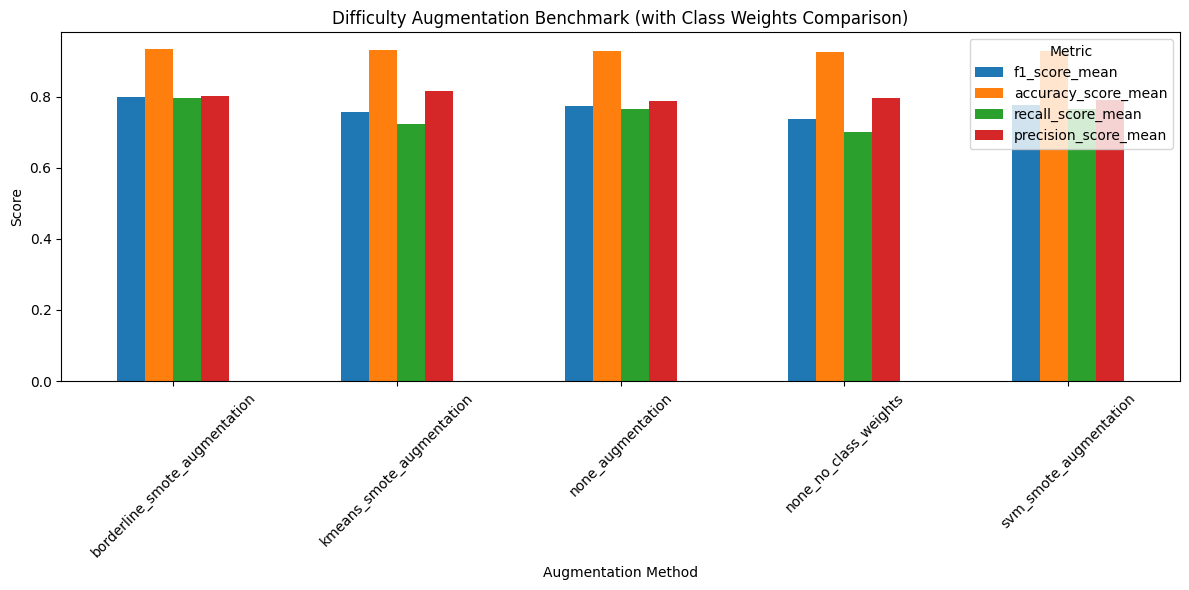


Best augmentation: borderline_smote


metric,f1_score_mean,accuracy_score_mean,recall_score_mean,precision_score_mean
augmentation,,,,
borderline_smote_augmentation,0.800177,0.935154,0.798262,0.803884
kmeans_smote_augmentation,0.756525,0.931741,0.722449,0.815436
none_augmentation,0.775571,0.929010,0.764783,0.788949
none_no_class_weights,0.736589,0.926962,0.702611,0.797142
svm_smote_augmentation,0.775983,0.929010,0.764644,0.790279


In [3]:
import os
csv_path = os.path.join(RESULTS_DIR, 'difficulty_aug_bar_xgb.csv')
if os.path.exists(csv_path):
    print(f"CSV already exists at {csv_path}, skipping runner.")
    pivot = pd.read_csv(csv_path, index_col=0)
else:
    runner = BenchmarkRunner(
        model_configs=[model_configs[3]],
        augmentations=augmentations,
        metrics=metrics,
        task_type='classification',
        device='cpu',
        epochs=150,
        batch_size=32,
        early_stopping=20,
        use_class_weights=True, 
        dropout=0.3,
        weight_decay=5e-4, 
        learning_rate=1e-4,
        path_start='difficulty', 
        max_factor=1.0  
    )
    # Use complete data - the pipeline will handle train/val splits internally
    aug_results = runner.run(X, y_enc)
    
    # Add comparison with use_class_weights=False for none augmentation
    print("\nRunning none augmentation with use_class_weights=False for comparison...")
    runner_no_weights = BenchmarkRunner(
        model_configs=[model_configs[3]],
        augmentations=[AUGMENTATION_REGISTRY['none']],  # Only none augmentation
        metrics=metrics,
        task_type='classification',
        device='cpu',
        epochs=150,
        batch_size=32,
        early_stopping=20,
        use_class_weights=False,  # This is the key difference
        dropout=0.3,
        weight_decay=5e-4, 
        learning_rate=1e-4,
        path_start='difficulty'
    )
    # Use complete data - the pipeline will handle train/val splits internally
    no_weights_results = runner_no_weights.run(X, y_enc)
    
    # Rename the augmentation to distinguish it
    no_weights_results['augmentation'] = 'none_no_class_weights'
    
    # Combine results
    combined_results = pd.concat([aug_results, no_weights_results], ignore_index=True)
    
    pivot = combined_results.pivot_table(index='augmentation', columns='metric', values='score')
    pivot.to_csv(csv_path)

# Keep only the relevant columns
pivot = pivot[['f1_score_mean', 'accuracy_score_mean', 'recall_score_mean', 'precision_score_mean']]
plot_metrics_bar(pivot, title='Difficulty Augmentation Benchmark (with Class Weights Comparison)')

# Normalize the four scores and select best augmentation by mean (excluding the no_class_weights comparison)
augmentations_to_compare = [idx for idx in pivot.index if not idx.endswith('_no_class_weights')]
pivot_for_selection = pivot.loc[augmentations_to_compare]

score_cols = ['f1_score_mean', 'accuracy_score_mean']
normed = pivot_for_selection[score_cols].copy()
normed = (normed - normed.min()) / (normed.max() - normed.min())
mean_score = normed.mean(axis=1)
best_aug_name = mean_score.idxmax()
best_aug_name = best_aug_name.replace('_augmentation', '')
if best_aug_name == '<lambda>':
    best_aug_name = 'mixup_smote'
best_augmentation = AUGMENTATION_REGISTRY[best_aug_name]
print(f'\nBest augmentation: {best_aug_name}')
pivot

Models:   0%|          | 0/1 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Running Model: xgboost_classifier | Augmentation: none_augmentation
Class distribution: {np.int64(0): np.int64(1332), np.int64(1): np.int64(133)}
Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5
  Fold 1 f1_score: 0.7571
Training fold 2/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2 f1_score: 0.6984
Training fold 3/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3 f1_score: 0.7246
Training fold 4/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 4 f1_score: 0.7297
Training fold 5/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 5 f1_score: 0.7731

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7366 ± 0.0261

accuracy_score : 0.9270 ± 0.0035
precision_score: 0.7971 ± 0.0197
recall_score   : 0.7026 ± 0.0326


Training final model on full dataset...


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Final model trained successfully on full dataset!

Running Model: xgboost_classifier | Augmentation: borderline_smote_augmentation
Class distribution: {np.int64(0): np.int64(1332), np.int64(1): np.int64(133)}
Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1 f1_score: 0.8032
Training fold 2/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2 f1_score: 0.7543
Training fold 3/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3 f1_score: 0.7731
Training fold 4/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 4 f1_score: 0.8026
Training fold 5/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 5 f1_score: 0.8251

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7916 ± 0.0249

accuracy_score : 0.9358 ± 0.0055
precision_score: 0.8153 ± 0.0192
recall_score   : 0.7749 ± 0.0359


Training final model on full dataset...


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Final model trained successfully on full dataset!

Running Model: xgboost_classifier | Augmentation: svm_smote_augmentation
Class distribution: {np.int64(0): np.int64(1332), np.int64(1): np.int64(133)}
Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1 f1_score: 0.7530
Training fold 2/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2 f1_score: 0.7813
Training fold 3/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3 f1_score: 0.7745
Training fold 4/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 4 f1_score: 0.7828
Training fold 5/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 5 f1_score: 0.7893

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7762 ± 0.0125

accuracy_score : 0.9270 ± 0.0035
precision_score: 0.7797 ± 0.0127
recall_score   : 0.7735 ± 0.0177


Training final model on full dataset...


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Final model trained successfully on full dataset!

Running Model: xgboost_classifier | Augmentation: kmeans_smote_augmentation
Class distribution: {np.int64(0): np.int64(1332), np.int64(1): np.int64(133)}
Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 1 f1_score: 0.7813
Training fold 2/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 2 f1_score: 0.7232
Training fold 3/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 3 f1_score: 0.7713
Training fold 4/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 4 f1_score: 0.8107
Training fold 5/5


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Fold 5 f1_score: 0.7958

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7765 ± 0.0298

accuracy_score : 0.9338 ± 0.0070
precision_score: 0.8136 ± 0.0315
recall_score   : 0.7502 ± 0.0322


Training final model on full dataset...


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:41:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "dropout" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Models: 100%|██████████| 1/1 [00:21<00:00, 21.24s/it]

✅ Final model trained successfully on full dataset!


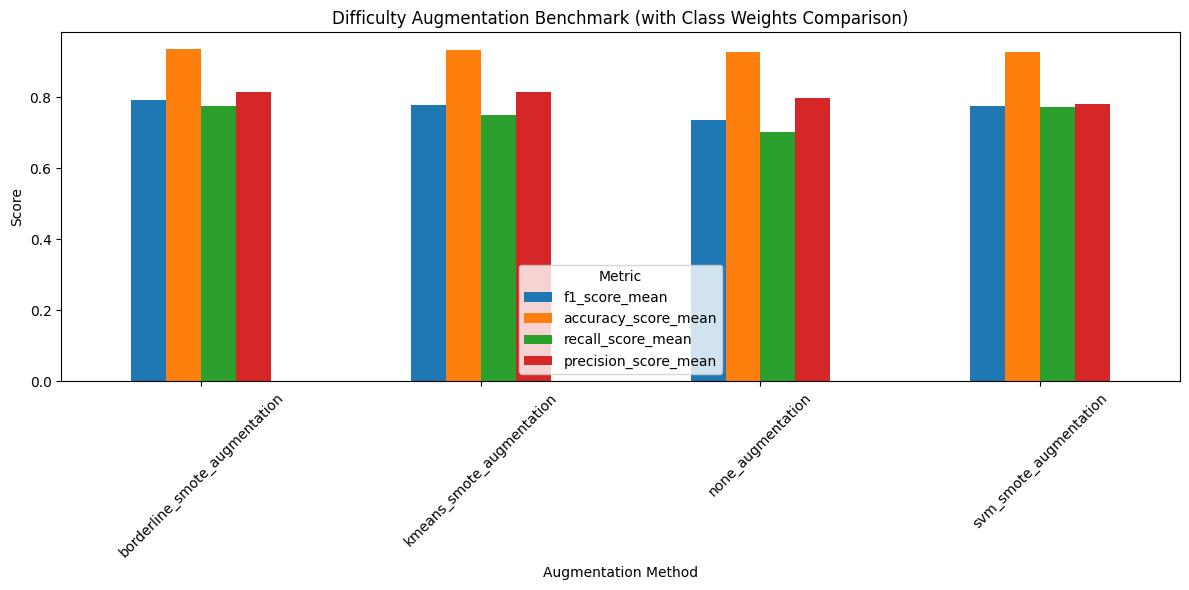


Best augmentation: borderline_smote


metric,f1_score_mean,accuracy_score_mean,recall_score_mean,precision_score_mean
augmentation,,,,
borderline_smote_augmentation,0.791640,0.935836,0.774908,0.815281
kmeans_smote_augmentation,0.776467,0.933788,0.750205,0.813647
none_augmentation,0.736589,0.926962,0.702611,0.797142
svm_smote_augmentation,0.776197,0.926962,0.773499,0.779746


In [14]:
import os
csv_path = os.path.join(RESULTS_DIR, 'difficulty2_aug_bar_xgb.csv')
if os.path.exists(csv_path):
    print(f"CSV already exists at {csv_path}, skipping runner.")
    pivot = pd.read_csv(csv_path, index_col=0)
else:
    runner = BenchmarkRunner(
        model_configs=[model_configs[3]],
        augmentations=augmentations,
        metrics=metrics,
        task_type='classification',
        device='cpu',
        epochs=150,
        batch_size=32,
        early_stopping=20,
        use_class_weights=False, 
        dropout=0.3,
        weight_decay=5e-4, 
        learning_rate=1e-4,
        path_start='difficulty2', 
        max_factor=1.5
    )
    # Use complete data - the pipeline will handle train/val splits internally
    aug_results = runner.run(X, y_enc)
    
    # Combine results
    combined_results = pd.concat([aug_results], ignore_index=True)

    pivot = combined_results.pivot_table(index='augmentation', columns='metric', values='score')
    pivot.to_csv(csv_path)

# Keep only the relevant columns
pivot = pivot[['f1_score_mean', 'accuracy_score_mean', 'recall_score_mean', 'precision_score_mean']]
plot_metrics_bar(pivot, title='Difficulty Augmentation Benchmark (with Class Weights Comparison)')

# Normalize the four scores and select best augmentation by mean (excluding the no_class_weights comparison)
augmentations_to_compare = [idx for idx in pivot.index if not idx.endswith('_no_class_weights')]
pivot_for_selection = pivot.loc[augmentations_to_compare]

score_cols = ['f1_score_mean', 'accuracy_score_mean']
normed = pivot_for_selection[score_cols].copy()
normed = (normed - normed.min()) / (normed.max() - normed.min())
mean_score = normed.mean(axis=1)
best_aug_name = mean_score.idxmax()
best_aug_name = best_aug_name.replace('_augmentation', '')
if best_aug_name == '<lambda>':
    best_aug_name = 'mixup_smote'
best_augmentation = AUGMENTATION_REGISTRY[best_aug_name]
print(f'\nBest augmentation: {best_aug_name}')
pivot


### 3. Training & Testing
Train and test all models using the best augmentation.


In [ ]:
best_aug_name = 'borderline_smote'
best_augmentation = AUGMENTATION_REGISTRY[best_aug_name]
for model_cfg in model_configs:
    model_name = model_cfg['name']
    metrics_path = os.path.join(RESULTS_DIR, f"difficulty_train/{model_name}_train_metrics.csv")
    if os.path.exists(metrics_path):
        print(f"Metrics already exist for {model_name}, skipping training.")
        continue
    model = model_cfg['class'](**model_cfg['params'])
    is_torch_model = hasattr(model, 'parameters')
    if is_torch_model:
        pipeline = GeneralPipeline(
            model=model,
            loss_fn='CrossEntropyLoss',
            optimizer_cls=torch.optim.Adam,
            optimizer_params={'lr': 1e-4, 'weight_decay': 5e-4},
            metrics=metrics,
            task_type='classification',
            device='cpu',
            epochs=150,
            batch_size=32,
            early_stopping=150,
            use_class_weights=False, 
            dropout=0.3, 
            augmentations=best_augmentation,
            max_factor=1.5,
        )
        history = pipeline.fit(X, y_enc)
    else:
        pipeline = GeneralPipelineSklearn(
            model=model,
            metrics=metrics,
            task_type='classification', 
            class_weight= None, 
            augmentations=best_augmentation,
            max_factor=1.5,
        )
        history = pipeline.fit(X,y_enc)
    save_model(model, model_name, path_start='difficulty_train')
    save_metrics(history, model_name, 'train', path_start='difficulty_train')

Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5
  Fold 1 f1_score: 0.7958
Training fold 2/5
  Fold 2 f1_score: 0.7435
Training fold 3/5
  Fold 3 f1_score: 0.7877
Training fold 4/5
  Fold 4 f1_score: 0.7890
Training fold 5/5
  Fold 5 f1_score: 0.8034

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7839 ± 0.0209

accuracy_score : 0.9365 ± 0.0041
precision_score: 0.8269 ± 0.0195
recall_score   : 0.7550 ± 0.0283


Training final model on full dataset...
✅ Final model trained successfully on full dataset!
Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5
  Fold 1 f1_score: 0.8032
Training fold 2/5
  Fold 2 f1_score: 0.7543
Training fold 3/5
  Fold 3 f1_score: 0.7731
Training fold 4/5
  Fold 4 f1_score: 0.8026
Training fold 5/5
  Fold 5 f1_score: 0.8251

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7916 ± 0.0249

accuracy_score : 0.9358 ± 0.0055


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 1 f1_score: 0.8349
Training fold 2/5
[LightGBM] [Info] Number of positive: 710, number of negative: 1063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195839
[LightGBM] [Info] Number of data points in the train set: 1773, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400451 -> initscore=-0.403585
[LightGBM] [Info] Start training from score -0.403585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 2 f1_score: 0.7169
Training fold 3/5
[LightGBM] [Info] Number of positive: 710, number of negative: 1064
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195839
[LightGBM] [Info] Number of data points in the train set: 1774, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400225 -> initscore=-0.404526
[LightGBM] [Info] Start training from score -0.404526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 3 f1_score: 0.7473
Training fold 4/5
[LightGBM] [Info] Number of positive: 710, number of negative: 1062
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1772, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400677 -> initscore=-0.402644
[LightGBM] [Info] Start training from score -0.402644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 4 f1_score: 0.8101
Training fold 5/5
[LightGBM] [Info] Number of positive: 710, number of negative: 1063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1773, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400451 -> initscore=-0.403585
[LightGBM] [Info] Start training from score -0.403585
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 5 f1_score: 0.7960

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7810 ± 0.0429

accuracy_score : 0.9345 ± 0.0113
precision_score: 0.8139 ± 0.0427
recall_score   : 0.7574 ± 0.0454


Training final model on full dataset...
[LightGBM] [Info] Number of positive: 888, number of negative: 1329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195837
[LightGBM] [Info] Number of data points in the train set: 2217, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400541 -> initscore=-0.403210
[LightGBM] [Info] Start training from score -0.403210
✅ Final model trained successfully on full dataset!


In [ ]:
for model_cfg in model_configs:
    model_name = model_cfg['name']
    metrics_path = os.path.join(RESULTS_DIR, f"difficulty_train2/{model_name}_train_metrics.csv")
    if os.path.exists(metrics_path):
        print(f"Metrics already exist for {model_name}, skipping training.")
        continue
    model = model_cfg['class'](**model_cfg['params'])
    is_torch_model = hasattr(model, 'parameters')
    if is_torch_model:
        pipeline = GeneralPipeline(
            model=model,
            loss_fn='CrossEntropyLoss',
            optimizer_cls=torch.optim.Adam,
            optimizer_params={'lr': 1e-4, 'weight_decay': 5e-4},
            metrics=metrics,
            task_type='classification',
            device='cpu',
            epochs=150,
            batch_size=32,
            early_stopping=150,
            use_class_weights=False, 
            dropout=0.3, 
            augmentations=None,
            max_factor=1,
        )
        history = pipeline.fit(X, y_enc)
    else:
        pipeline = GeneralPipelineSklearn(
            model=model,
            metrics=metrics,
            task_type='classification', 
            class_weight= None, 
            augmentations=None,
        )
        history = pipeline.fit(X,y_enc)
    save_model(model, model_name, path_start='difficulty_train2')
    save_metrics(history, model_name, 'train', path_start='difficulty_train2')

Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5
  Fold 1 f1_score: 0.7771
Training fold 2/5
  Fold 2 f1_score: 0.7113
Training fold 3/5
  Fold 3 f1_score: 0.7336
Training fold 4/5
  Fold 4 f1_score: 0.7390
Training fold 5/5
  Fold 5 f1_score: 0.7390

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7400 ± 0.0212

accuracy_score : 0.9372 ± 0.0027
precision_score: 0.9057 ± 0.0337
recall_score   : 0.6813 ± 0.0245


Training final model on full dataset...
✅ Final model trained successfully on full dataset!
Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5
  Fold 1 f1_score: 0.7571
Training fold 2/5
  Fold 2 f1_score: 0.6984
Training fold 3/5
  Fold 3 f1_score: 0.7246
Training fold 4/5
  Fold 4 f1_score: 0.7297
Training fold 5/5
  Fold 5 f1_score: 0.7731

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7366 ± 0.0261

accuracy_score : 0.9270 ± 0.0035


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 1 f1_score: 0.8034
Training fold 2/5
[LightGBM] [Info] Number of positive: 107, number of negative: 1065
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195828
[LightGBM] [Info] Number of data points in the train set: 1172, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.091297 -> initscore=-2.297901
[LightGBM] [Info] Start training from score -2.297901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 2 f1_score: 0.7116
Training fold 3/5
[LightGBM] [Info] Number of positive: 106, number of negative: 1066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195831
[LightGBM] [Info] Number of data points in the train set: 1172, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090444 -> initscore=-2.308230
[LightGBM] [Info] Start training from score -2.308230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 3 f1_score: 0.7116
Training fold 4/5
[LightGBM] [Info] Number of positive: 106, number of negative: 1066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195831
[LightGBM] [Info] Number of data points in the train set: 1172, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090444 -> initscore=-2.308230
[LightGBM] [Info] Start training from score -2.308230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 4 f1_score: 0.7954
Training fold 5/5
[LightGBM] [Info] Number of positive: 106, number of negative: 1066
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195831
[LightGBM] [Info] Number of data points in the train set: 1172, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090444 -> initscore=-2.308230
[LightGBM] [Info] Start training from score -2.308230
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 5 f1_score: 0.8034

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7651 ± 0.0438

accuracy_score : 0.9379 ± 0.0079
precision_score: 0.8559 ± 0.0246
recall_score   : 0.7187 ± 0.0454


Training final model on full dataset...
[LightGBM] [Info] Number of positive: 133, number of negative: 1332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1465, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090785 -> initscore=-2.304088
[LightGBM] [Info] Start training from score -2.304088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Final model trained successfully on full dataset!



### 4. Evaluation
Evaluate the classification models using an external test dataset.


Unique difficulty labels after mapping (test): ['Easy' 'More effort']
Validation set class distribution:
Class Easy: 490
Class More effort: 124
Test results saved to results/difficulty_test_results.csv


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


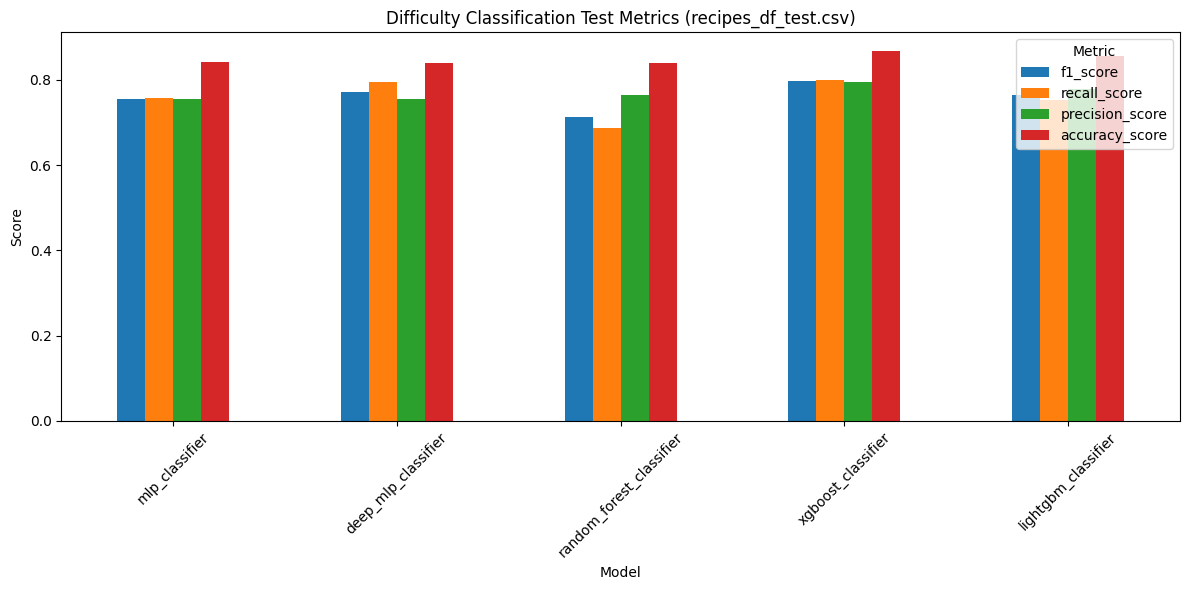

,f1_score,recall_score,precision_score,accuracy_score,model
0,0.755681,0.756452,0.754920,0.842020,mlp_classifier
1,0.770993,0.794585,0.754884,0.840391,deep_mlp_classifier
2,0.711952,0.686159,0.764771,0.840391,random_forest_classifier
3,0.797192,0.799885,0.794605,0.868078,xgboost_classifier
4,0.764289,0.752567,0.778790,0.855049,lightgbm_classifier


In [ ]:
# Preprocess test set
test_df = load_csv('recipes_df_test_bis.csv')
test_df = test_df.dropna(subset=['embeddings_class', 'difficult'])
test_df['difficult'] = test_df['difficult'].replace({'A challenge': 'More effort'})
print('Unique difficulty labels after mapping (test):', test_df['difficult'].unique())
X_test, y_test = prepare_embeddings_data(test_df, target_column='difficult', embedding_column='embeddings_class')
le_test = LabelEncoderHelper(); le_test.fit(y_test)
y_test_enc = le.transform(y_test)  # Use train label encoder for consistency
unique, counts = np.unique(y_test, return_counts=True)
class_dist = dict(zip(unique, counts))
print("Validation set class distribution:")
for cls, cnt in class_dist.items():
    print(f"Class {cls}: {cnt}")
# Evaluate all models
test_results = []
for model_cfg in model_configs:
    model_name = model_cfg['name']
    # Load trained model
    model = load_model(model_cfg['class'], model_name, model_cfg['params'], path_start='difficulty_train')
    is_torch_model = hasattr(model, 'parameters')
    pipeline = SimplePredictor(
        model=model,
        task_type='classification'
    )
    y_pred = pipeline.predict(X_test)
    # Collect metrics
    result = {}
    for metric in metrics:
        metric_key = getattr(metric, 'name', None) or getattr(metric, '__name__', None) or str(metric)
        result[metric_key] = metric(y_test_enc, y_pred)
    result['model'] = model_name
    test_results.append(result)

# Save test results
test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv(os.path.join(RESULTS_DIR, "difficulty_test_results.csv"), index=False)
print("Test results saved to", os.path.join(RESULTS_DIR, "difficulty_test_results.csv"))

# Plot grouped bar chart of metrics for all models
import matplotlib.pyplot as plt
test_results_df.set_index('model').plot(kind='bar', figsize=(12,6))
plt.title("Difficulty Classification Test Metrics (recipes_df_test.csv)")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

test_results_df

Unique difficulty labels after mapping (test): ['Easy' 'More effort']
Validation set class distribution:
Class Easy: 490
Class More effort: 124
Test results saved to results/difficulty_test_results_2.csv


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


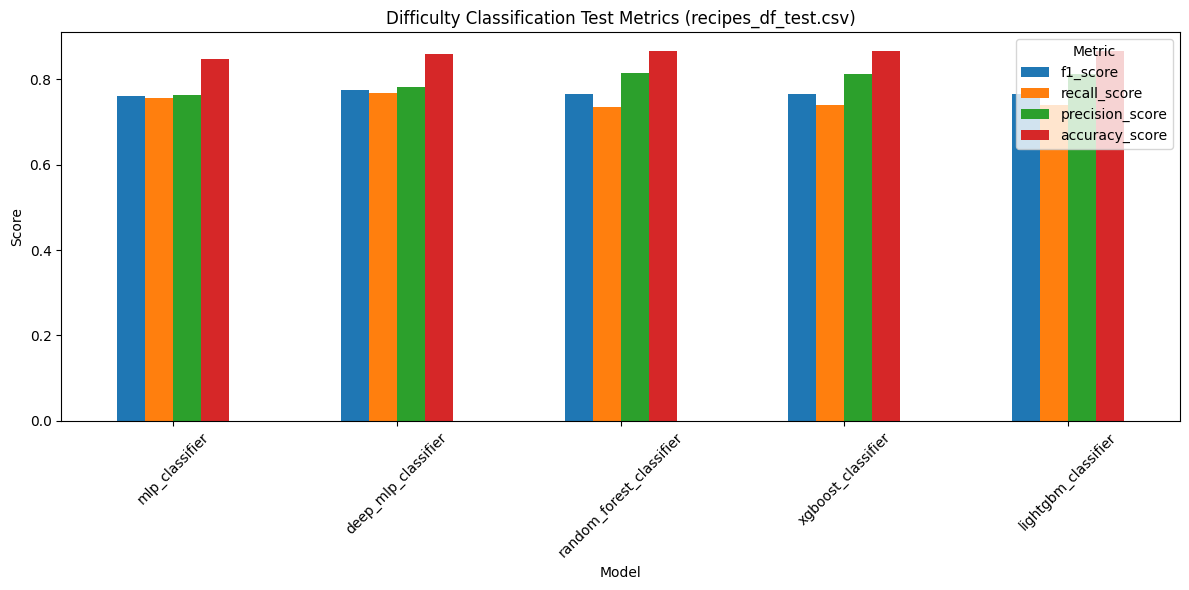

,f1_score,recall_score,precision_score,accuracy_score,model
0,0.759613,0.756501,0.762905,0.846906,mlp_classifier
1,0.774008,0.766656,0.782339,0.858306,deep_mlp_classifier
2,0.764487,0.735616,0.815275,0.866450,random_forest_classifier
3,0.766249,0.738627,0.813235,0.866450,xgboost_classifier
4,0.766249,0.738627,0.813235,0.866450,lightgbm_classifier


In [ ]:
# Preprocess test set
test_df = load_csv('recipes_df_test_bis.csv')
test_df = test_df.dropna(subset=['embeddings_class', 'difficult'])
test_df['difficult'] = test_df['difficult'].replace({'A challenge': 'More effort'})
print('Unique difficulty labels after mapping (test):', test_df['difficult'].unique())
X_test, y_test = prepare_embeddings_data(test_df, target_column='difficult', embedding_column='embeddings_class')
le_test = LabelEncoderHelper(); le_test.fit(y_test)
y_test_enc = le.transform(y_test)  # Use train label encoder for consistency
unique, counts = np.unique(y_test, return_counts=True)
class_dist = dict(zip(unique, counts))
print("Validation set class distribution:")
for cls, cnt in class_dist.items():
    print(f"Class {cls}: {cnt}")
# Evaluate all models
test_results = []
for model_cfg in model_configs:
    model_name = model_cfg['name']
    # Load trained model
    model = load_model(model_cfg['class'], model_name, model_cfg['params'], path_start='difficulty_train2')
    is_torch_model = hasattr(model, 'parameters')
    pipeline = SimplePredictor(
        model=model,
        task_type='classification'
    )
    y_pred = pipeline.predict(X_test)
    # Collect metrics
    result = {}
    for metric in metrics:
        metric_key = getattr(metric, 'name', None) or getattr(metric, '__name__', None) or str(metric)
        result[metric_key] = metric(y_test_enc, y_pred)
    result['model'] = model_name
    test_results.append(result)

# Save test results
test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv(os.path.join(RESULTS_DIR, "difficulty_test_results_2.csv"), index=False)
print("Test results saved to", os.path.join(RESULTS_DIR, "difficulty_test_results_2.csv"))

# Plot grouped bar chart of metrics for all models
import matplotlib.pyplot as plt
test_results_df.set_index('model').plot(kind='bar', figsize=(12,6))
plt.title("Difficulty Classification Test Metrics (recipes_df_test.csv)")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

test_results_df

### 5. Tuning a Xgboost model with Optuna

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import xgboost as xgb
import optuna

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, random_state=42)
best_aug_name = 'borderline_smote'
best_augmentation = AUGMENTATION_REGISTRY[best_aug_name]
X_train, y_train = best_augmentation(X_train, y_train)

def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
        'n_jobs': -1,
        'num_class': len(np.unique(y_train)),
    }
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')
    return score

# 2. Create and run the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # n_trials can be increased for a more thorough search

# 3. Get and print the best parameters
best_xgb_params = study.best_trial.params
print("Best trial score (F1 Macro):", study.best_value)
print("Best trial parameters:")
print(best_xgb_params)

[I 2025-08-04 00:22:24,985] A new study created in memory with name: no-name-25ea49a4-fbfb-4dcd-9425-988eb4b54639
[I 2025-08-04 00:22:29,692] Trial 0 finished with value: 0.7695731866980885 and parameters: {'n_estimators': 1500, 'learning_rate': 0.15550156691159728, 'max_depth': 4, 'subsample': 0.904961203932463, 'colsample_bytree': 0.6208452751410996, 'gamma': 0.13294985703954199, 'reg_alpha': 0.03165421606814223, 'reg_lambda': 6.2413769324321535}. Best is trial 0 with value: 0.7695731866980885.
[I 2025-08-04 00:22:33,995] Trial 1 finished with value: 0.78 and parameters: {'n_estimators': 800, 'learning_rate': 0.16849124252472295, 'max_depth': 3, 'subsample': 0.9901841919887246, 'colsample_bytree': 0.6211099846057859, 'gamma': 0.43859834920636165, 'reg_alpha': 0.7118585390464103, 'reg_lambda': 7.706724547365107}. Best is trial 1 with value: 0.78.
[I 2025-08-04 00:22:38,535] Trial 2 finished with value: 0.7705399895699996 and parameters: {'n_estimators': 900, 'learning_rate': 0.1949089

Best trial score (F1 Macro): 0.8028399697152304
Best trial parameters:
{'n_estimators': 700, 'learning_rate': 0.17168842741226328, 'max_depth': 7, 'subsample': 0.7828234953937935, 'colsample_bytree': 0.9938679774389333, 'gamma': 0.08890713718433918, 'reg_alpha': 0.6808255295738511, 'reg_lambda': 9.062502241811243}


In [5]:
# Get the xgboost model config
xgb_config = next((config for config in model_configs if config['name'] == 'xgboost_classifier'), None)
if xgb_config:
    model_name = "xgboost_classifier_tuned"
    print(f"--- Training {model_name} with best parameters ---")

    # Instantiate model with the tuned hyperparameters
    tuned_model = xgb_config['class'](**best_xgb_params)

    # Use the Sklearn pipeline to fit the model
    pipeline = GeneralPipelineSklearn(
        model=tuned_model,
        metrics=metrics,
        task_type='classification', 
        class_weight=None, 
        augmentations=best_augmentation,  # Use the best augmentation found earlier
        max_factor=1.5,
    )
    history = pipeline.fit(X, y_enc)

    # Save the tuned model and its training metrics
    save_model(tuned_model, model_name, path_start='difficulty_train')
    save_metrics(history, model_name, 'train', path_start='difficulty_train')
    print(f"--- Finished training and saved model: {model_name} ---")
else:
    print("XGBoost configuration not found in model_configs.")

--- Training xgboost_classifier_tuned with best parameters ---
Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5
  Fold 1 f1_score: 0.8101
Training fold 2/5
  Fold 2 f1_score: 0.7504
Training fold 3/5
  Fold 3 f1_score: 0.8101
Training fold 4/5
  Fold 4 f1_score: 0.8026
Training fold 5/5
  Fold 5 f1_score: 0.7960

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.7938 ± 0.0223

accuracy_score : 0.9338 ± 0.0051
precision_score: 0.8018 ± 0.0177
recall_score   : 0.7874 ± 0.0293


Training final model on full dataset...
✅ Final model trained successfully on full dataset!
--- Finished training and saved model: xgboost_classifier_tuned ---


In [ ]:
# Load the test data (reusing preprocessing from your notebook)
test_df = load_csv('recipes_df_test_bis.csv')
test_df = test_df.dropna(subset=['embeddings_class', 'difficult'])
test_df['difficult'] = test_df['difficult'].replace({'A challenge': 'More effort'})
X_test, y_test = prepare_embeddings_data(test_df, target_column='difficult', embedding_column='embeddings_class')
y_test_enc = le.transform(y_test) # Use the label encoder fitted on the training data

# Load the tuned model
xgb_config = next((config for config in model_configs if config['name'] == 'xgboost_classifier'), None)
tuned_model = load_model(xgb_config['class'], model_name, best_xgb_params, path_start='difficulty_train')

# Create pipeline for evaluation
pipeline = SimplePredictor(
    model=tuned_model,
    task_type='classification'
)
# Get predictions
y_pred = pipeline.predict(X_test)

# Calculate and display metrics
tuned_results = {}
for metric in metrics:
    metric_key = getattr(metric, 'name', metric.__name__)
    tuned_results[metric_key] = metric(y_test_enc, y_pred)
tuned_results['model'] = model_name

tuned_results_df = pd.DataFrame([tuned_results])
tuned_results_df

,f1_score,recall_score,precision_score,accuracy_score,model
0,0.783448,0.787739,0.779437,0.858306,xgboost_classifier_tuned


## Meal Type Classification
### 1. Data Preprocessing
Load and preprocess data for meal type classification.

In [7]:
meal_types = ['Lunch recipes', 'Dinner recipes', 'Breakfast recipes']
meal_df = filter_meal_types(load_csv('recipes_df.csv'), meal_types)
if 'embeddings_class' in meal_df.columns and not meal_df['embeddings_class'].isnull().any():
    X_meal, y_meal = prepare_embeddings_data(meal_df, target_column='meal_type', embedding_column='embeddings_class')
    le_meal = LabelEncoderHelper(); le_meal.fit(y_meal)
    y_meal_enc = le_meal.transform(y_meal)
    X_train_meal, X_val_meal, _, y_train_meal, y_val_meal, _ = train_val_test_split(X_meal, y_meal_enc, val_size=0.15, test_size=0, stratify=y_meal_enc)
    input_dim = X_train_meal.shape[1]
    num_classes = len(np.unique(y_train_meal))
    model_names = [
        'mlp_classifier', 'deep_mlp_classifier', 'random_forest_classifier', 'xgboost_classifier', 'lightgbm_classifier'
    ]
    model_configs = [
        {
            'name': name,
            'class': MODEL_REGISTRY[name],
            'params': {'input_dim': input_dim, 'num_classes': num_classes} if 'mlp' in name or 'transformer' in name else {}
        }
        for name in model_names
    ]
    metrics = [METRIC_REGISTRY['f1'], METRIC_REGISTRY['recall'], METRIC_REGISTRY['precision'], METRIC_REGISTRY['accuracy']]
    unique, counts = np.unique(y_val_meal, return_counts=True)
    class_dist = dict(zip(unique, counts))
    print("Validation set class distribution:")
    for cls, cnt in class_dist.items():
        print(f"Class {cls}: {cnt}")

Validation set class distribution:
Class 0: 11
Class 1: 13
Class 2: 17


### 2. Data augmentation
Since the number of instances in the dataset is limited, I need to do LLM data augmentation in order to train the model.

In [5]:
# --- Augment 50 samples per class using 5 methods ---
from data_augmentation.text_aug import TEXT_AUGMENTATION_REGISTRY
import random

API_KEY = os.getenv("GOOGLE_API_KEY")
aug_methods = [
    "llm_paraphrase",
    "llm_synonym",
    "llm_style",
    "classical_synonym",
    "classical_mixed"
]
N_PER_CLASS = 50

augmented_texts = []
augmented_labels = []
for class_id in np.unique(y_train_meal):
    class_name = le_meal.inverse_transform([class_id])[0]
    class_texts = meal_df[meal_df['meal_type'] == class_name]['recipe_text'].tolist()
    # If not enough, sample with replacement
    if len(class_texts) < N_PER_CLASS:
        class_texts = random.choices(class_texts, k=N_PER_CLASS)
    else:
        class_texts = random.sample(class_texts, N_PER_CLASS)
    per_method = max(1, N_PER_CLASS // len(aug_methods))
    class_augmented = []
    for aug_method in aug_methods:
        if aug_method.startswith("llm_"):
            augmented = TEXT_AUGMENTATION_REGISTRY[aug_method](class_texts, api_key=API_KEY)
        else:
            augmented = TEXT_AUGMENTATION_REGISTRY[aug_method](class_texts)
        flat_aug = [x[0] for x in augmented if x and x[0]]
        class_augmented.extend(random.sample(flat_aug, min(per_method, len(flat_aug))))
    class_augmented = class_augmented[:N_PER_CLASS]
    augmented_texts.extend(class_augmented)
    augmented_labels.extend([class_id] * len(class_augmented))

print(f"Generated {len(augmented_texts)} augmented samples ({N_PER_CLASS} per class).")
for i in range(min(5, len(augmented_texts))):
    print(f"Augmented sample {i+1}: {augmented_texts[i]} (label={augmented_labels[i]})")

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


Generated 150 augmented samples (50 per class).
Augmented sample 1: Here are several ways to paraphrase "name: ingredients: steps:" depending on the context you're aiming for:

**General Paraphrases:**

*   **What you need and how to make it:** This is a very straightforward and common way to rephrase it.
*   **Components and instructions:** More formal and concise.
*   **Required items and procedure:** Similar to components and instructions, but emphasizes the "required" aspect.
*   **Materials and method:** Common in scientific or technical contexts.
*   **What to use and how to do it:** Simple and action-oriented.
*   **The list of items and the process:** Focuses on the nature of the information being presented.
*   **Recipe details:** If the context is clearly about cooking or a similar process.

**More specific paraphrases depending on the implied context:**

**If it's for a recipe:**

*   **Recipe Name, Ingredients, and Instructions:** Very direct and clear for a recipe.
*   **T

In [6]:
# --- Embed augmented samples and add to training set ---
from google import genai
from google.genai import types
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

@retry.Retry(predicate=is_retriable, timeout=600.0)
def embed_fn_class(text: str) -> list[float]:
    client = genai.Client(api_key=GOOGLE_API_KEY)
    response = client.models.embed_content(
        model="models/text-embedding-004",
        contents=text,
        config=types.EmbedContentConfig(
            task_type="classification",
        ),
    )
    return response.embeddings[0].values

aug_embeds = []
for text in augmented_texts:
    try:
        emb = embed_fn_class(text)
        aug_embeds.append(emb)
    except Exception as e:
        print(f"Embedding failed for: {text[:30]}... Error: {e}")

if len(aug_embeds) == len(augmented_labels):
    import numpy as np
    X_train_meal = np.vstack([X_train_meal, np.array(aug_embeds)])
    y_train_meal = np.concatenate([y_train_meal, np.array(augmented_labels)])
    print(f"Added {len(aug_embeds)} embedded augmented samples to training set, distributed per class.")
else:
    print("Some embeddings failed, not all augmented samples were added to training set.")

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.
Both GOOGLE_API_KEY 

Added 150 embedded augmented samples to training set, distributed per class.


In [8]:
import os
np.save(os.path.join(RESULTS_DIR, 'meal_data/X_train_meal.npy'), X_train_meal)
np.save(os.path.join(RESULTS_DIR, 'meal_data/y_train_meal.npy'), y_train_meal)
np.save(os.path.join(RESULTS_DIR, 'meal_data/X_val_meal.npy'), X_val_meal)
np.save(os.path.join(RESULTS_DIR, 'meal_data/y_val_meal.npy'), y_val_meal)

### 3. Training & Testing
Train and test all models using the augmented training set.

In [ ]:
# Load X_train_meal, y_train_meal, X_val_meal, y_val_meal
X_train_meal = np.load(os.path.join(RESULTS_DIR, 'meal_data/X_train_meal.npy'))
y_train_meal = np.load(os.path.join(RESULTS_DIR, 'meal_data/y_train_meal.npy'))
X_val_meal = np.load(os.path.join(RESULTS_DIR, 'meal_data/X_val_meal.npy'))
y_val_meal = np.load(os.path.join(RESULTS_DIR, 'meal_data/y_val_meal.npy'))
for model_cfg in model_configs:
    model_name = model_cfg['name']
    metrics_path = os.path.join(RESULTS_DIR, f"meal_train/{model_name}_train_metrics.csv")
    if os.path.exists(metrics_path):
        print(f"Metrics already exist for {model_name}, skipping training.")
        continue
    model = model_cfg['class'](**model_cfg['params'])
    is_torch_model = hasattr(model, 'parameters')
    if is_torch_model:
        pipeline = GeneralPipeline(
            model=model,
            loss_fn='CrossEntropyLoss',
            optimizer_cls=torch.optim.Adam,
            optimizer_params={'lr': 2e-4, 'weight_decay': 1e-4},
            metrics=metrics,
            task_type='classification',
            device='cpu',
            epochs=800,
            batch_size=32,
            early_stopping=40,
            use_class_weights=True, 
            dropout=0.3, 
            use_kfold=False
        )
        history = pipeline._single_fit_internal(X_train_meal, y_train_meal, X_val_meal, y_val_meal)
    else:
        pipeline = GeneralPipelineSklearn(
            model=model,
            metrics=metrics,
            task_type='classification',
            class_weight= 'balanced'
        )
        history = pipeline.internal_fit(X_train_meal, y_train_meal, X_val_meal, y_val_meal, model=model)
    save_model(model, model_name, path_start='meal_train')
    save_metrics(history, model_name, 'train', path_start='meal_train')

Computed class weights: {np.int64(0): np.float64(1.1381381381381381), np.int64(1): np.float64(1.0026455026455026), np.int64(2): np.float64(0.8896713615023474)}
Epoch 1/800 - Train Loss: 1.0987, Val Loss: 1.0974, F1: 0.1954
Epoch 2/800 - Train Loss: 1.1000, Val Loss: 1.0974, F1: 0.1954
Epoch 3/800 - Train Loss: 1.0981, Val Loss: 1.0971, F1: 0.1954
Epoch 4/800 - Train Loss: 1.0996, Val Loss: 1.0966, F1: 0.1954
Epoch 5/800 - Train Loss: 1.0982, Val Loss: 1.0961, F1: 0.1954
Epoch 6/800 - Train Loss: 1.0966, Val Loss: 1.0954, F1: 0.1954
Epoch 7/800 - Train Loss: 1.0964, Val Loss: 1.0944, F1: 0.1954
Epoch 8/800 - Train Loss: 1.0960, Val Loss: 1.0927, F1: 0.1954
Epoch 9/800 - Train Loss: 1.0948, Val Loss: 1.0909, F1: 0.4532
Epoch 10/800 - Train Loss: 1.0933, Val Loss: 1.0876, F1: 0.4222
Epoch 11/800 - Train Loss: 1.0902, Val Loss: 1.0825, F1: 0.5074
Epoch 12/800 - Train Loss: 1.0860, Val Loss: 1.0767, F1: 0.5745
Epoch 13/800 - Train Loss: 1.0820, Val Loss: 1.0663, F1: 0.5074
Epoch 14/800 - Tr


### 5. Evaluation
Generate plots and metrics for all models.


Unique meal type labels (test): ['Breakfast recipes' 'Dinner recipes' 'Lunch recipes']
Test set class distribution:
Class Breakfast recipes: 81
Class Dinner recipes: 154
Class Lunch recipes: 124
Test results saved to results/meal_type_test_results.csv


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


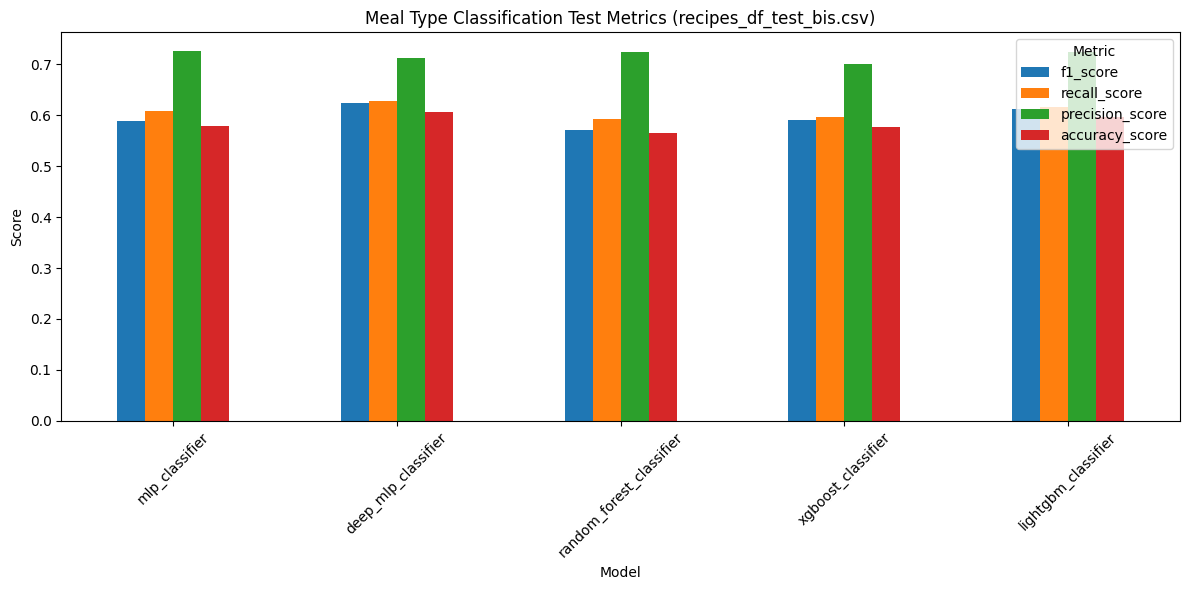

,f1_score,recall_score,precision_score,accuracy_score,model
0,0.588224,0.607451,0.726349,0.579387,mlp_classifier
1,0.623622,0.627381,0.711350,0.607242,deep_mlp_classifier
2,0.571710,0.591824,0.724642,0.565460,random_forest_classifier
3,0.589797,0.596292,0.700800,0.576602,xgboost_classifier
4,0.612127,0.616393,0.724761,0.596100,lightgbm_classifier


In [ ]:
# Preprocess test set
test_df = load_csv('recipes_df_test.csv')

# Create meal_type column based on dish_type
def extract_meal_type(dish_type):
    dish_type_lower = str(dish_type).lower()
    if 'lunch' in dish_type_lower:
        return 'Lunch recipes'
    elif 'dinner' in dish_type_lower:
        return 'Dinner recipes'
    elif 'breakfast' in dish_type_lower:
        return 'Breakfast recipes'
    else:
        return None

test_df['meal_type'] = test_df['dish_type'].apply(extract_meal_type)

meal_types = ['Lunch recipes', 'Dinner recipes', 'Breakfast recipes']
test_meal_df = test_df[test_df['meal_type'].isin(meal_types)]
test_meal_df = test_meal_df.dropna(subset=['embeddings_class', 'meal_type'])
print('Unique meal type labels (test):', test_meal_df['meal_type'].unique())
X_test, y_test = prepare_embeddings_data(test_meal_df, target_column='meal_type', embedding_column='embeddings_class')
le_test = LabelEncoderHelper(); 
le_test.fit(y_test)
y_test_enc = le_test.transform(y_test)  # Use train label encoder for consistency
unique, counts = np.unique(y_test, return_counts=True)
class_dist = dict(zip(unique, counts))
print("Test set class distribution:")
for cls, cnt in class_dist.items():
    print(f"Class {cls}: {cnt}")

# Evaluate all models
test_results = []
for model_cfg in model_configs:
    model_name = model_cfg['name']
    # Load trained model
    model = load_model(model_cfg['class'], model_name, model_cfg['params'], path_start='meal_train')
    is_torch_model = hasattr(model, 'parameters')
    pipeline = SimplePredictor(
        model=model,
        task_type='classification'
    )
    # Inference
    y_pred = pipeline.predict(X_test)
    # Collect metrics
    result = {}
    for metric in metrics:
        metric_key = getattr(metric, 'name', None) or getattr(metric, '__name__', None) or str(metric)
        result[metric_key] = metric(y_test_enc, y_pred)
    result['model'] = model_name
    test_results.append(result)

# Save test results
test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv(os.path.join(RESULTS_DIR, "meal_type_test_results.csv"), index=False)
print("Test results saved to", os.path.join(RESULTS_DIR, "meal_type_test_results.csv"))

# Plot grouped bar chart of metrics for all models
import matplotlib.pyplot as plt
test_results_df.set_index('model').plot(kind='bar', figsize=(12,6))
plt.title("Meal Type Classification Test Metrics (recipes_df_test_bis.csv)")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

test_results_df


--- Per-Class Analysis for Best Model: deep_mlp_classifier ---

Classification Report:
                   precision    recall  f1-score     support
Breakfast recipes   0.894737  0.629630  0.739130   81.000000
Dinner recipes      0.759494  0.389610  0.515021  154.000000
Lunch recipes       0.479821  0.862903  0.616715  124.000000
accuracy            0.607242  0.607242  0.607242    0.607242
macro avg           0.711350  0.627381  0.623622  359.000000
weighted avg        0.693408  0.607242  0.600712  359.000000


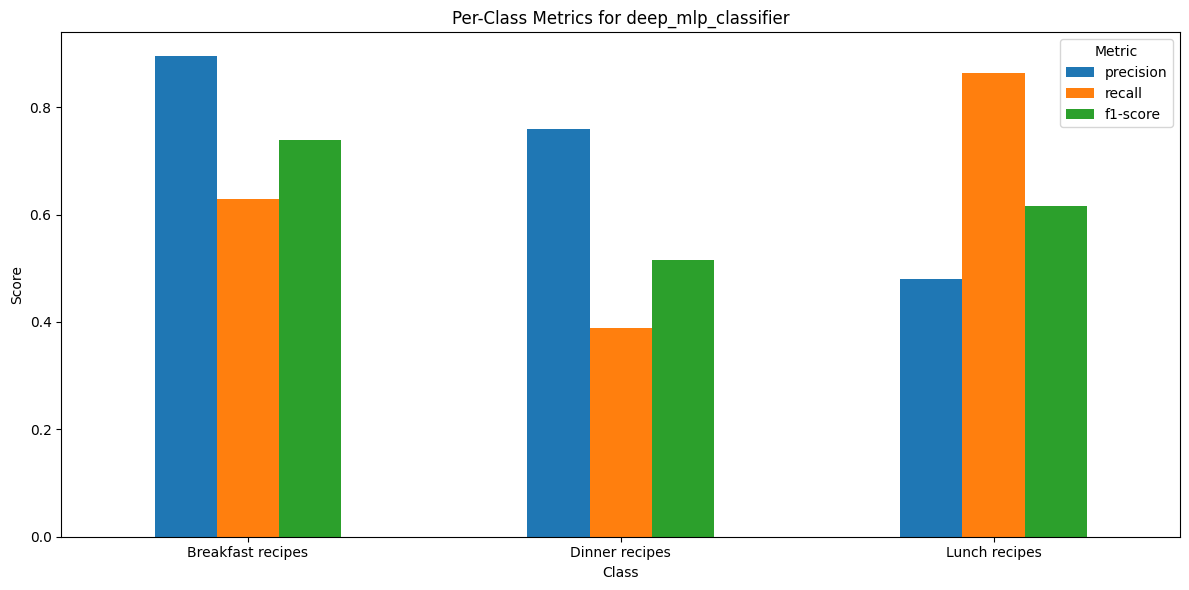


One-vs-Rest Confusion Matrices:


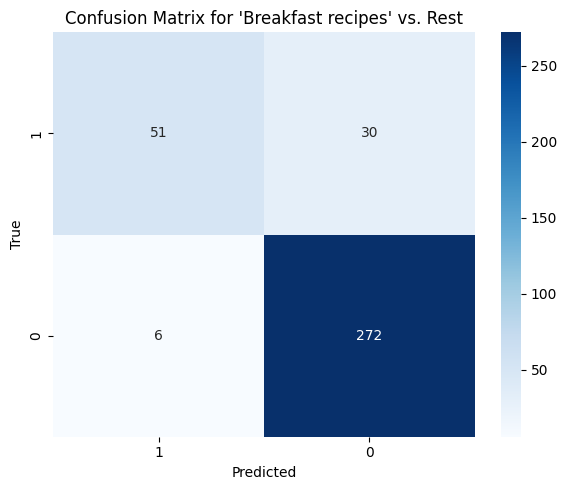

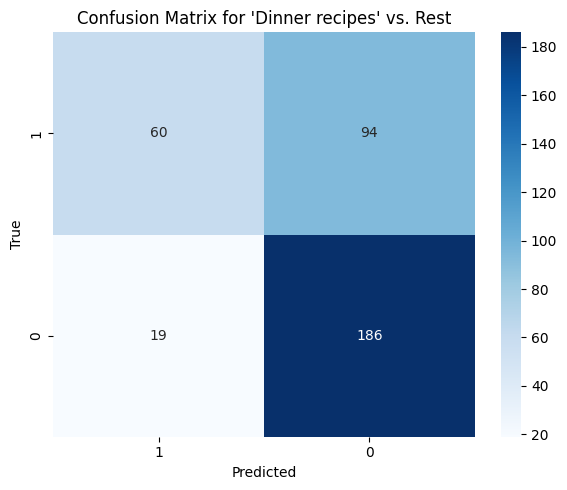

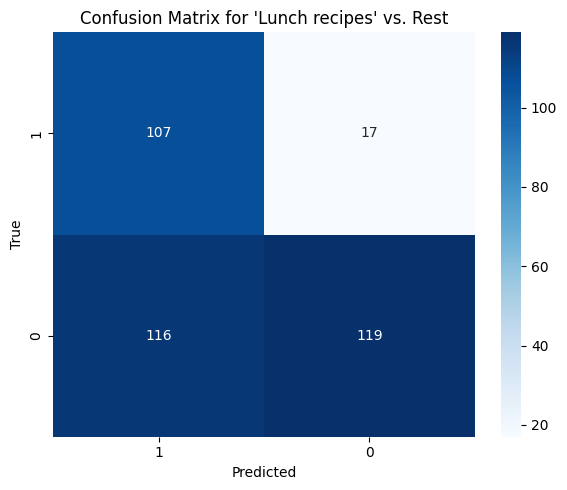

In [ ]:
from sklearn.metrics import classification_report
from utils.visualization import plot_per_class_metrics

# 1. Find the best model based on F1-score
best_model_name = test_results_df.loc[test_results_df['f1_score'].idxmax()]['model']
print(f"\n--- Per-Class Analysis for Best Model: {best_model_name} ---")

# 2. Get predictions for the best model again
best_model_cfg = next(cfg for cfg in model_configs if cfg['name'] == best_model_name)
model = load_model(best_model_cfg['class'], best_model_name, best_model_cfg['params'], path_start='meal_train')

is_torch_model = hasattr(model, 'parameters')
pipeline = SimplePredictor(
    model=model,
    task_type='classification'
)
y_pred_best = pipeline.predict(X_test)

# 3. Generate and plot per-class metrics
class_names = le_test.classes()
report = classification_report(y_test_enc, y_pred_best, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("\nClassification Report:")
print(report_df)

plot_per_class_metrics(report_df, title=f"Per-Class Metrics for {best_model_name}")

# 4. Generate and plot one-vs-rest confusion matrices for each class
print("\nOne-vs-Rest Confusion Matrices:")
for i, class_name in enumerate(class_names):
    # Binarize true and predicted labels for the current class
    y_true_ovr = (y_test_enc == i).astype(int)
    y_pred_ovr = (y_pred_best == i).astype(int)
    
    plot_confusion_matrix(
        y_true_ovr, 
        y_pred_ovr, 
        labels=[1, 0],  # Positive class (1) first
        title=f"Confusion Matrix for '{class_name}' vs. Rest"
    )

In [11]:
# --- New: Breakfast vs. Non-Breakfast Analysis ---
print("\n--- Analysis: Breakfast vs. Non-Breakfast ---")

# 1. Identify the integer label for 'Breakfast recipes'
try:
    # Convert to list just in case it's not
    class_names_list = list(class_names)
    breakfast_idx = class_names_list.index('Breakfast recipes')
except ValueError:
    print("Error: 'Breakfast recipes' not found in class labels.")
else:
    # 2. Create binary labels: 1 for Breakfast, 0 for Non-Breakfast (Lunch/Dinner)
    y_true_binary = (y_test_enc == breakfast_idx).astype(int)
    y_pred_binary = (y_pred_best == breakfast_idx).astype(int)
    
    binary_target_names = ['Non-Breakfast', 'Breakfast'] # 0, 1
    
    # 3. Generate and print the binary classification report
    binary_report = classification_report(
        y_true_binary, 
        y_pred_binary, 
        target_names=binary_target_names, 
        output_dict=True
    )
    binary_report_df = pd.DataFrame(binary_report).transpose()
    
    # Filter to show only the per-class metrics and make a copy
    binary_class_report_df = binary_report_df.loc[binary_target_names].copy()
    
    # Add the overall accuracy as a new column
    binary_class_report_df['accuracy'] = binary_report['accuracy']
    
binary_class_report_df


--- Analysis: Breakfast vs. Non-Breakfast ---


,precision,recall,f1-score,support,accuracy
Non-Breakfast,0.900662,0.978417,0.937931,278.0,0.899721
Breakfast,0.894737,0.629630,0.739130,81.0,0.899721



## Nutrient Value Prediction (Multi-output Regression)
### 1. Data Preprocessing
Load and preprocess data for nutrient regression.


In [8]:
import ast
nutrient_df = load_csv('recipes_df.csv')
nutrient_keys = set()
for val in nutrient_df['nutrients'].dropna():
    try:
        d = ast.literal_eval(val) if isinstance(val, str) else val
        if isinstance(d, dict):
            nutrient_keys.update(d.keys())
    except Exception:
        continue
nutrient_keys = sorted([k for k in nutrient_keys if k])
def parse_nutrients(row):
    try:
        d = ast.literal_eval(row) if isinstance(row, str) else row
        if not isinstance(d, dict):
            return [None]*len(nutrient_keys)
        vals = []
        for k in nutrient_keys:
            v = d.get(k, None)
            if v is None or v == '':
                return [None]*len(nutrient_keys)
            v = v.replace('g','').replace('kcal','').strip()
            try:
                vals.append(float(v))
            except Exception:
                return [None]*len(nutrient_keys)
        return vals
    except Exception:
        return [None]*len(nutrient_keys)
nutrient_df['nutrient_vec'] = nutrient_df['nutrients'].apply(parse_nutrients)
valid_nutrient_df = nutrient_df[nutrient_df['nutrient_vec'].apply(lambda x: None not in x)]
if 'embeddings_reg' in valid_nutrient_df.columns and not valid_nutrient_df['embeddings_reg'].isnull().any():
    X_nutr, y_nutr = prepare_embeddings_data(valid_nutrient_df, target_column='nutrient_vec', embedding_column='embeddings_reg')
    X_train_nutr, X_val_nutr, _, y_train_nutr, y_val_nutr, _ = train_val_test_split(X_nutr, np.vstack(y_nutr), val_size=0.15, test_size=0, stratify=None)
    input_dim = X_train_nutr.shape[1]
    output_dim = y_train_nutr.shape[1]


### 2. Model Setup
Define model configurations and metrics for nutrient regression.


In [10]:
model_names = [
    'mlp_regressor', 
    'deep_mlp_regressor', 
    'random_forest_regressor', 
    'xgboost_regressor', 
    'lightgbm_regressor'
]
model_configs = [
    {
        'name': name,
        'class': MODEL_REGISTRY[name],
        'params': {'input_dim': input_dim, 'output_dim': output_dim} if 'mlp' in name else {}
    }
    for name in model_names
]
metrics = [METRIC_REGISTRY['mse'], METRIC_REGISTRY['mae'], METRIC_REGISTRY['r2']]


### 3. Training & Testing
Train and test all models for nutrient regression.


In [4]:
for model_cfg in model_configs:
    model_name = model_cfg['name']
    metrics_path = os.path.join(RESULTS_DIR, f"nutrient_train/{model_name}_train_metrics.csv")
    if os.path.exists(metrics_path):
        print(f"Metrics already exist for {model_name}, skipping training.")
        continue
    model = model_cfg['class'](**model_cfg['params'])
    is_torch_model = hasattr(model, 'parameters')
    if is_torch_model:
        pipeline = GeneralPipeline(
            model=model,
            loss_fn='MSELoss',
            optimizer_cls=torch.optim.Adam,
            optimizer_params={'lr': 1e-4, 'weight_decay': 1e-5},
            metrics=metrics,
            task_type='regression',
            device='cpu',
            epochs=2000,
            batch_size=32,
            early_stopping=30,
            use_class_weights=False
        )
        history = pipeline.fit(X_nutr, np.vstack(y_nutr))
    else:
        pipeline = GeneralPipelineSklearn(
            model=model,
            metrics=metrics,
            task_type='regression'
        )
        history = pipeline.fit(X_nutr, np.vstack(y_nutr))

    save_model(model, model_name, path_start='nutrient_train')
    save_metrics(history, model_name, 'train', path_start='nutrient_train')

Metrics already exist for mlp_regressor, skipping training.
Starting 5-fold cross-validation with weight averaging ensemble
Starting 5-fold cross-validation with weight averaging ensemble...
Training fold 1/5
Epoch 1/2000 - Train Loss: 21169.0663, Val Loss: 24226.7957, R²: -2.1317
Epoch 2/2000 - Train Loss: 21161.8317, Val Loss: 24221.2932, R²: -2.1541
Epoch 3/2000 - Train Loss: 21154.0653, Val Loss: 24213.0357, R²: -2.1470
Epoch 4/2000 - Train Loss: 21147.8131, Val Loss: 24216.3316, R²: -2.1793
Epoch 5/2000 - Train Loss: 21136.0234, Val Loss: 24205.3270, R²: -2.1536
Epoch 6/2000 - Train Loss: 21119.9376, Val Loss: 24201.2920, R²: -2.1263
Epoch 7/2000 - Train Loss: 21115.4342, Val Loss: 24193.5850, R²: -2.1183
Epoch 8/2000 - Train Loss: 21107.0207, Val Loss: 24186.9911, R²: -2.0921
Epoch 9/2000 - Train Loss: 21094.9821, Val Loss: 24185.3703, R²: -2.0893
Epoch 10/2000 - Train Loss: 21088.9117, Val Loss: 24176.4775, R²: -2.0700
Epoch 11/2000 - Train Loss: 21072.6852, Val Loss: 24166.2907

/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 142055
[LightGBM] [Info] Number of data points in the train set: 554, number of used features: 768
[LightGBM] [Info] Start training from score 38.350814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages

  Fold 3 r2_score: 0.5312
Training fold 4/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 142208
[LightGBM] [Info] Number of data points in the train set: 555, number of used features: 768
[LightGBM] [Info] Start training from score 39.426398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 142240
[LightGBM] [Info] Number of data points in the train set: 555, number of used features: 768
[LightGBM] [Info] Start training from score 38.584596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


### 4. Evaluation
Generate plots and metrics for all models.


Test results already exist at results/nutrient_test_results.csv, loading from file.
Index(['mean_squared_error', 'mean_absolute_error', 'r2_score', 'model'], dtype='object')


,mean_squared_error,mean_absolute_error,r2_score,model
0,2251.695252,13.894439,-0.080863,mlp_regressor
1,3356.568364,19.402996,-0.177062,deep_mlp_regressor
2,2679.995981,14.170260,0.249467,random_forest_regressor
3,2822.069703,12.905022,0.165675,xgboost_regressor
4,2491.646117,11.749758,0.324851,lightgbm_regressor


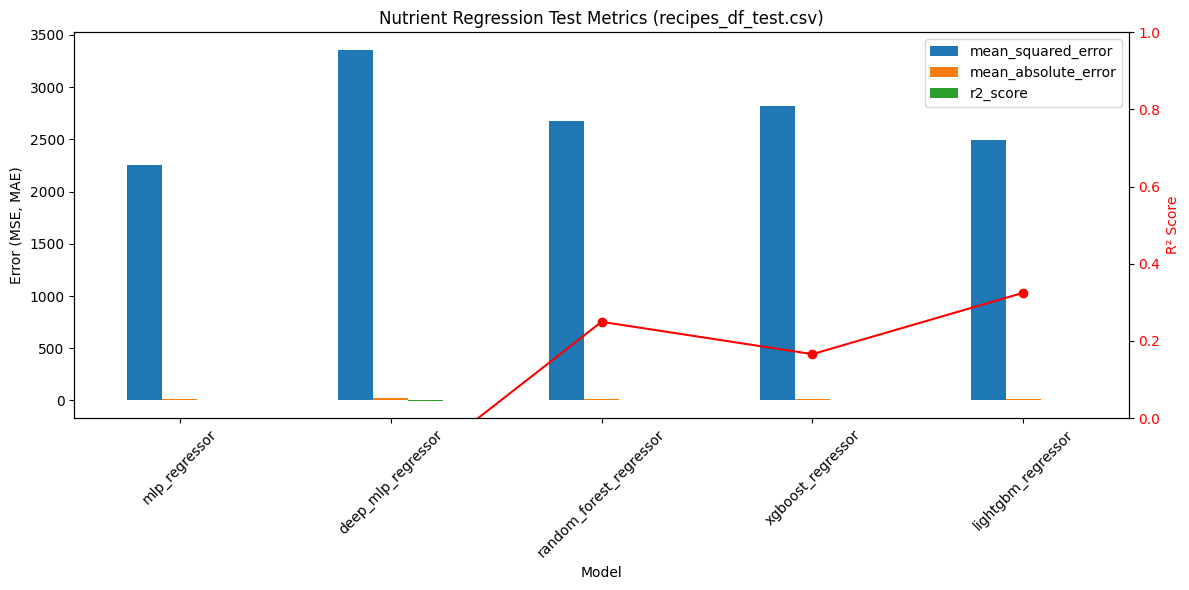

In [ ]:
# --- 4. Evaluation on External Dataset ---
import matplotlib.pyplot as plt

# --- Preprocess Test Set ---
test_results_path = os.path.join(RESULTS_DIR, "nutrient_test_results.csv")

if os.path.exists(test_results_path):
    print(f"Test results already exist at {test_results_path}, loading from file.")
    test_results_df = pd.read_csv(test_results_path)
    # Reload test data for detailed analysis later
    test_df = load_csv('recipes_df_test.csv')
    test_df = test_df.dropna(subset=['embeddings_reg', 'nutrients'])
    test_df['nutrient_vec'] = test_df['nutrients'].apply(parse_nutrients)
    valid_test_df = test_df[test_df['nutrient_vec'].apply(lambda x: None not in x)]
    X_test, y_test_list = prepare_embeddings_data(valid_test_df, target_column='nutrient_vec', embedding_column='embeddings_reg')
    y_test = np.vstack(y_test_list)
else:
    print("Evaluating models on external recipes_df_test.csv dataset...")
    test_df = load_csv('recipes_df_test.csv')
    test_df = test_df.dropna(subset=['embeddings_reg', 'nutrients'])
    
    test_df['nutrient_vec'] = test_df['nutrients'].apply(parse_nutrients)
    valid_test_df = test_df[test_df['nutrient_vec'].apply(lambda x: None not in x)]
    
    X_test, y_test_list = prepare_embeddings_data(valid_test_df, target_column='nutrient_vec', embedding_column='embeddings_reg')
    y_test = np.vstack(y_test_list)

    # --- Evaluate all models ---
    test_results = []
    for model_cfg in model_configs:
        model_name = model_cfg['name']
        
        # Load trained model
        model = load_model(model_cfg['class'], model_name, model_cfg['params'], path_start='nutrient_train')
        is_torch_model = hasattr(model, 'parameters')

        pipeline = SimplePredictor(
        model=model,
        task_type='regression',
    )
        # Inference
        y_pred = pipeline.predict(X_test)
        
        # Collect metrics
        result = {}
        for metric in metrics:
            metric_key = metric.__name__  # Use the function's actual name
            result[metric_key] = metric(y_test, y_pred)
        result['model'] = model_name
        test_results.append(result)

    # Save test results
    test_results_df = pd.DataFrame(test_results)
    test_results_df.to_csv(test_results_path, index=False)
    print("Test results saved to", test_results_path)

# --- Visualize Results ---
# Plot grouped bar chart of metrics for all models
fig, ax1 = plt.subplots(figsize=(12, 6))
print(test_results_df.columns)
test_results_df.set_index('model')[['mean_squared_error', 'mean_absolute_error', 'r2_score']].plot(kind='bar', ax=ax1)
ax1.set_ylabel('Error (MSE, MAE)')
ax1.set_xlabel('Model')
ax1.set_title("Nutrient Regression Test Metrics (recipes_df_test.csv)")
ax1.tick_params(axis='x', rotation=45)

# Plot R2 score on a secondary y-axis
ax2 = ax1.twinx()
test_results_df.set_index('model')['r2_score'].plot(kind='line', marker='o', color='r', ax=ax2)
ax2.set_ylabel('R² Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, max(1.0, test_results_df['r2_score'].max() * 1.1)) # Adjust ylim dynamically

fig.tight_layout()

test_results_df

Test results already exist at results/nutrient_test_results2.csv, loading from file.
Index(['mean_squared_error', 'mean_absolute_error', 'r2_score', 'model'], dtype='object')


,mean_squared_error,mean_absolute_error,r2_score,model
0,4540.916213,25.074321,-0.580470,mlp_regressor
1,5206.609524,28.436743,-0.898783,deep_mlp_regressor
2,3934.462625,23.927085,-0.046640,random_forest_regressor
3,5001.886972,24.589608,-0.049582,xgboost_regressor
4,3775.959101,21.651998,0.130723,lightgbm_regressor


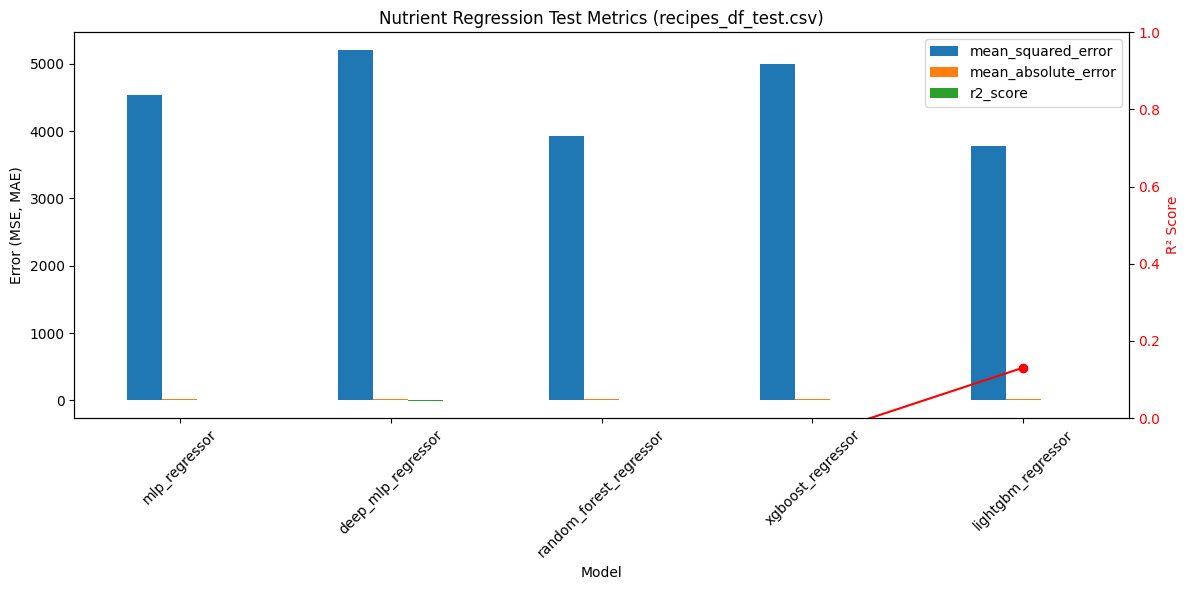

In [ ]:
# --- 4. Evaluation on External Dataset ---
import matplotlib.pyplot as plt

# --- Preprocess Test Set ---
test_results_path = os.path.join(RESULTS_DIR, "nutrient_test_results2.csv")

if os.path.exists(test_results_path):
    print(f"Test results already exist at {test_results_path}, loading from file.")
    test_results_df2 = pd.read_csv(test_results_path)
    # Reload test data for detailed analysis later
    test_df = load_csv('recipes_df_test_bis.csv')
    test_df = test_df.dropna(subset=['embeddings_reg', 'nutrients'])
    test_df['nutrient_vec'] = test_df['nutrients'].apply(parse_nutrients)
    valid_test_df = test_df[test_df['nutrient_vec'].apply(lambda x: None not in x)]
    X_test, y_test_list = prepare_embeddings_data(valid_test_df, target_column='nutrient_vec', embedding_column='embeddings_reg')
    y_test = np.vstack(y_test_list)
else:
    print("Evaluating models on external recipes_df_test.csv dataset...")
    test_df = load_csv('recipes_df_test_bis.csv')
    test_df = test_df.dropna(subset=['embeddings_reg', 'nutrients'])
    
    test_df['nutrient_vec'] = test_df['nutrients'].apply(parse_nutrients)
    valid_test_df = test_df[test_df['nutrient_vec'].apply(lambda x: None not in x)]
    
    X_test, y_test_list = prepare_embeddings_data(valid_test_df, target_column='nutrient_vec', embedding_column='embeddings_reg')
    y_test = np.vstack(y_test_list)

    # --- Evaluate all models ---
    test_results = []
    for model_cfg in model_configs:
        model_name = model_cfg['name']
        
        # Load trained model
        model = load_model(model_cfg['class'], model_name, model_cfg['params'], path_start='nutrient_train')
        is_torch_model = hasattr(model, 'parameters')

        pipeline = SimplePredictor(
        model=model,
        task_type='regression',
    )
        y_pred = pipeline.predict(X_test)
        
        # Collect metrics
        result = {}
        for metric in metrics:
            metric_key = metric.__name__  # Use the function's actual name
            result[metric_key] = metric(y_test, y_pred)
        result['model'] = model_name
        test_results.append(result)

    # Save test results
    test_results_df2 = pd.DataFrame(test_results)
    test_results_df2.to_csv(test_results_path, index=False)
    print("Test results saved to", test_results_path)

# --- Visualize Results ---
# Plot grouped bar chart of metrics for all models
fig, ax1 = plt.subplots(figsize=(12, 6))
print(test_results_df2.columns)
test_results_df2.set_index('model')[['mean_squared_error', 'mean_absolute_error', 'r2_score']].plot(kind='bar', ax=ax1)
ax1.set_ylabel('Error (MSE, MAE)')
ax1.set_xlabel('Model')
ax1.set_title("Nutrient Regression Test Metrics (recipes_df_test.csv)")
ax1.tick_params(axis='x', rotation=45)

# Plot R2 score on a secondary y-axis
ax2 = ax1.twinx()
test_results_df2.set_index('model')['r2_score'].plot(kind='line', marker='o', color='r', ax=ax2)
ax2.set_ylabel('R² Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, max(1.0, test_results_df2['r2_score'].max() * 1.1)) # Adjust ylim dynamically

fig.tight_layout()

test_results_df2


--- Detailed Analysis for Best Model: lightgbm_regressor ---


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages

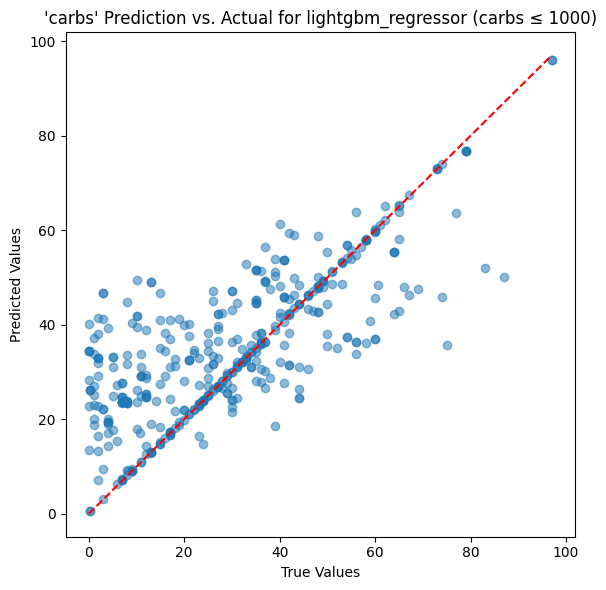

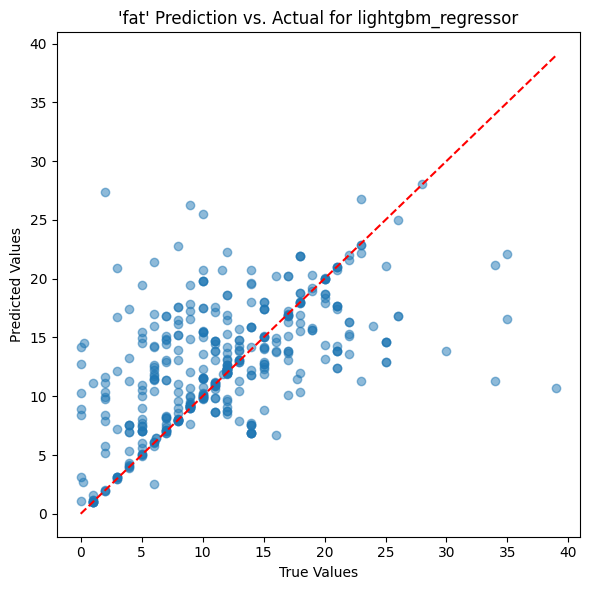

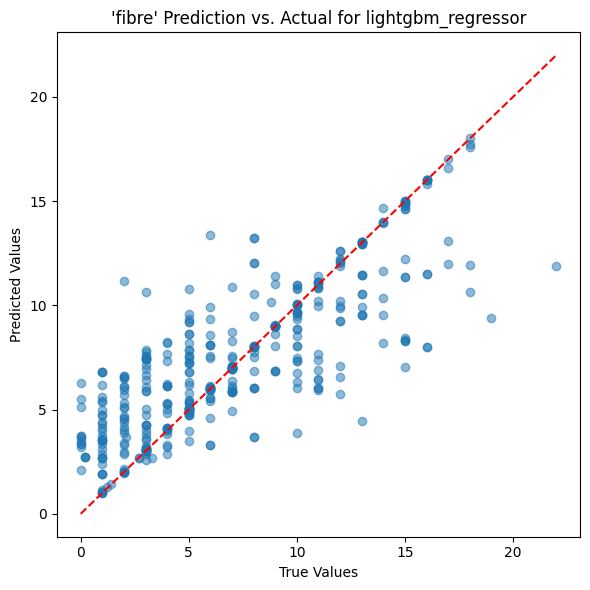

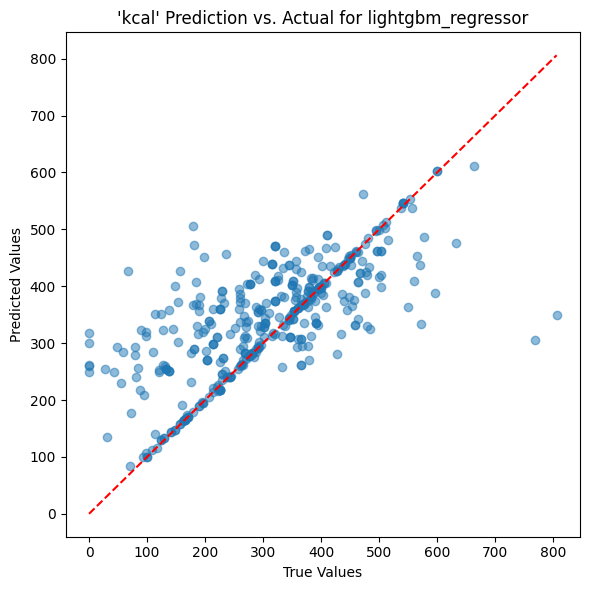

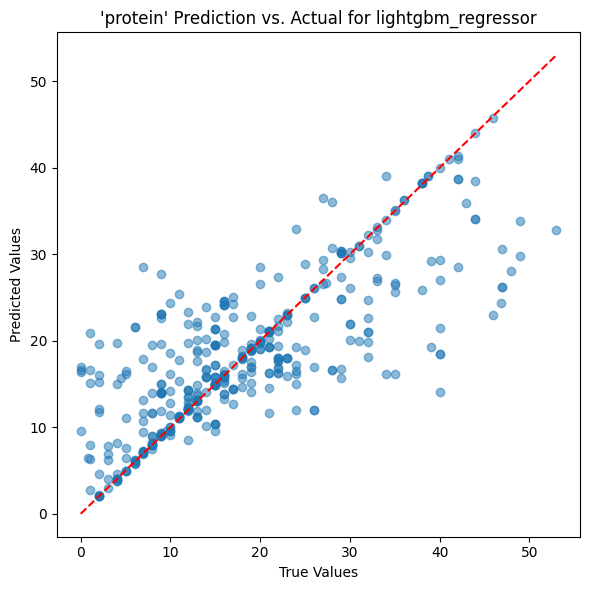

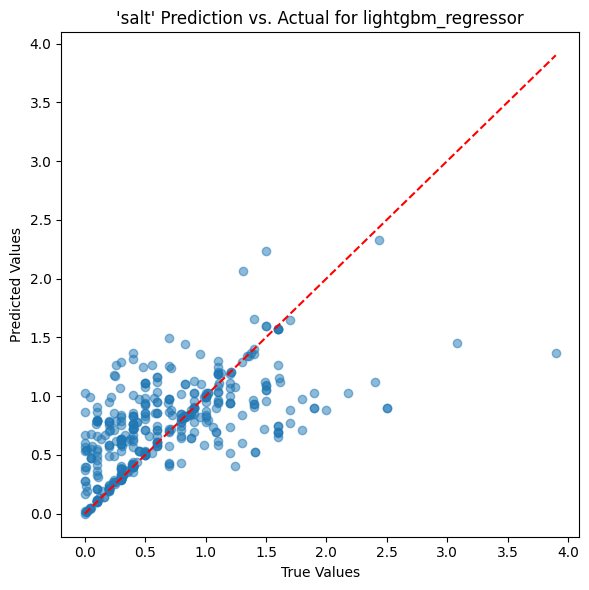

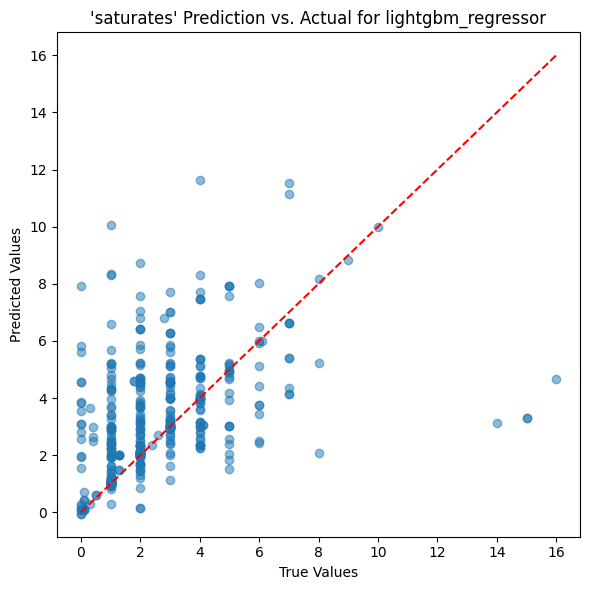

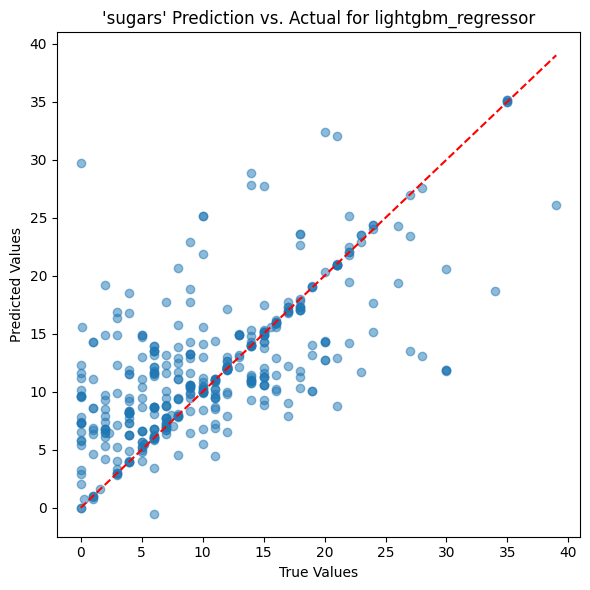

In [ ]:
# --- Detailed Analysis for Best Model ---
# Find the best model based on R2 score
best_model_name = test_results_df.loc[test_results_df['r2_score'].idxmax()]['model']
print(f"\n--- Detailed Analysis for Best Model: {best_model_name} ---")

# Get predictions for the best model again
best_model_cfg = next(cfg for cfg in model_configs if cfg['name'] == best_model_name)
model = load_model(best_model_cfg['class'], best_model_name, best_model_cfg['params'], path_start='nutrient_train')

test_df = load_csv('recipes_df_test.csv')
test_df = test_df.dropna(subset=['embeddings_reg', 'nutrients'])

test_df['nutrient_vec'] = test_df['nutrients'].apply(parse_nutrients)
valid_test_df = test_df[test_df['nutrient_vec'].apply(lambda x: None not in x)]

X_test, y_test_list = prepare_embeddings_data(valid_test_df, target_column='nutrient_vec', embedding_column='embeddings_reg')
y_test = np.vstack(y_test_list)

is_torch_model = hasattr(model, 'parameters')
pipeline = SimplePredictor(
    model=model,
    task_type='regression',
)
y_pred_best = pipeline.predict(X_test)

# Plot regression results for each nutrient
for i, nutrient_name in enumerate(nutrient_keys):
    if nutrient_name.lower() == "carbs":
        # Remove outliers where carbs > 1000
        mask = y_test[:, i] <= 1000
        plot_regression_results(
            y_test[mask, i],
            y_pred_best[mask, i],
            title=f"'{nutrient_name}' Prediction vs. Actual for {best_model_name} (carbs ≤ 1000)"
        )
    else:
        plot_regression_results(
            y_test[:, i], 
            y_pred_best[:, i], 
            title=f"'{nutrient_name}' Prediction vs. Actual for {best_model_name}"
        )


## Time Prediction (Single-output Regression)
### 1. Data Preprocessing
Load and preprocess data for total time regression.


In [ ]:
time_df = load_csv('recipes_df.csv')
def parse_time(row):
    import ast
    try:
        d = ast.literal_eval(row) if isinstance(row, str) else row
        if not isinstance(d, dict):
            return [None, None]
        prep = d.get('Preparation', '0').replace('No Time','0').replace('mins','').replace('min','').strip()
        cook = d.get('Cooking', '0').replace('No Time','0').replace('mins','').replace('min','').strip()
        try:
            prep = int(round(float(prep)))
        except Exception:
            prep = 0
        try:
            cook = int(round(float(cook)))
        except Exception:
            cook = 0
        return [prep, cook]
    except Exception:
        return [None, None]
time_df['time_vec'] = time_df['times'].apply(parse_time)
time_df['total_time'] = time_df['time_vec'].apply(lambda x: sum(x) if None not in x else None)
valid_time_df = time_df[time_df['time_vec'].apply(lambda x: None not in x) & time_df['total_time'].notnull()]
X_total_time, y_total_time = prepare_embeddings_data(valid_time_df, target_column='total_time', embedding_column='embeddings_reg')
X_train_total, X_val_total, _, y_train_total, y_val_total, _ = train_val_test_split(X_total_time, np.vstack(y_total_time), val_size=0.15, test_size=0, stratify=None)
input_dim = X_train_total.shape[1]
output_dim = y_train_total.shape[1]

### 2. Model Setup
Define model configurations and metrics for total time regression.

In [35]:
model_names = [
    'mlp_regressor', 
    'deep_mlp_regressor', 
    'random_forest_regressor', 
    'xgboost_regressor', 
    'lightgbm_regressor'
]
model_configs = [
    {
        'name': name,
        'class': MODEL_REGISTRY[name],
        'params': {'input_dim': input_dim, 'output_dim': output_dim} if 'mlp' in name else {}
    }
    for name in model_names
]
metrics = [METRIC_REGISTRY['mse'], METRIC_REGISTRY['mae'], METRIC_REGISTRY['r2']]

### 3. Training & Testing
Train and test all models for total time regression.


In [39]:
for model_cfg in model_configs:
    model_name = model_cfg['name']
    metrics_path = os.path.join(RESULTS_DIR, f"total_time_train/{model_name}_train_metrics.csv")
    if os.path.exists(metrics_path):
        print(f"Metrics already exist for {model_name}, skipping training.")
        continue
    model = model_cfg['class'](**model_cfg['params'])
    is_torch_model = hasattr(model, 'parameters')
    is_lightgbm_multioutput = model_name == "lightgbm_regressor"
    if is_torch_model:
        pipeline = GeneralPipeline(
            model=model,
            loss_fn='MSELoss',
            optimizer_cls=torch.optim.Adam,
            optimizer_params={'lr': 1e-4, 'weight_decay': 1e-4},
            metrics=metrics,
            task_type='regression',
            device='cpu',
            epochs=600,
            batch_size=32,
            early_stopping=20,
            use_class_weights=False
        )
        history = pipeline.fit(X_total_time, np.vstack(y_total_time).flatten())
    else:
        pipeline = GeneralPipelineSklearn(
            model=model,
            metrics=metrics,
            task_type='regression'
        )
        if is_lightgbm_multioutput:
            # LightGBM MultiOutputRegressor expects 2D targets
            history = pipeline.fit(X_total_time, np.array(y_total_time).reshape(-1, 1))
        else:
            history = pipeline.fit(X_total_time, np.vstack(y_total_time).flatten())
    save_model(model, model_name, path_start='total_time_train')
    save_metrics(history, model_name, 'train', path_start='total_time_train')

Metrics already exist for mlp_regressor, skipping training.
Metrics already exist for deep_mlp_regressor, skipping training.
Metrics already exist for random_forest_regressor, skipping training.
Metrics already exist for xgboost_regressor, skipping training.
Starting 5-fold cross-validation for sklearn model
Starting 5-fold cross-validation for sklearn model...
Training fold 1/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195833
[LightGBM] [Info] Number of data points in the train set: 1172, number of used features: 768
[LightGBM] [Info] Start training from score 30.841297


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  Fold 1 r2_score: 0.4218
Training fold 2/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195835
[LightGBM] [Info] Number of data points in the train set: 1172, number of used features: 768
[LightGBM] [Info] Start training from score 29.910410


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  Fold 2 r2_score: 0.4449
Training fold 3/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195837
[LightGBM] [Info] Number of data points in the train set: 1172, number of used features: 768
[LightGBM] [Info] Start training from score 30.497440


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  Fold 3 r2_score: 0.4082
Training fold 4/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195832
[LightGBM] [Info] Number of data points in the train set: 1172, number of used features: 768
[LightGBM] [Info] Start training from score 30.526451


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  Fold 4 r2_score: 0.4119
Training fold 5/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195830
[LightGBM] [Info] Number of data points in the train set: 1172, number of used features: 768
[LightGBM] [Info] Start training from score 29.616894


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


  Fold 5 r2_score: 0.4524

CROSS-VALIDATION RESULTS
🎯 R2_SCORE       : 0.4278 ± 0.0177

mean_absolute_error: 9.7223 ± 0.4835
mean_squared_error: 207.6156 ± 15.6434


Training final model on full dataset...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 1465, number of used features: 768
[LightGBM] [Info] Start training from score 30.278498
✅ Final model trained successfully on full dataset!



### 4. Evaluation
Generate plots and metrics for all models.


Evaluating models on external recipes_df_test.csv dataset for total time prediction...
Test results saved to results/total_time_test_results.csv
Index(['mean_squared_error', 'mean_absolute_error', 'r2_score', 'model'], dtype='object')


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,mean_squared_error,mean_absolute_error,r2_score,model
0,120.568214,7.730434,0.615951,mlp_regressor
1,129.333130,7.873534,0.588032,deep_mlp_regressor
2,141.771642,8.839185,0.548411,random_forest_regressor
3,145.327972,7.971886,0.537083,xgboost_regressor
4,128.018776,7.605142,0.592219,lightgbm_regressor


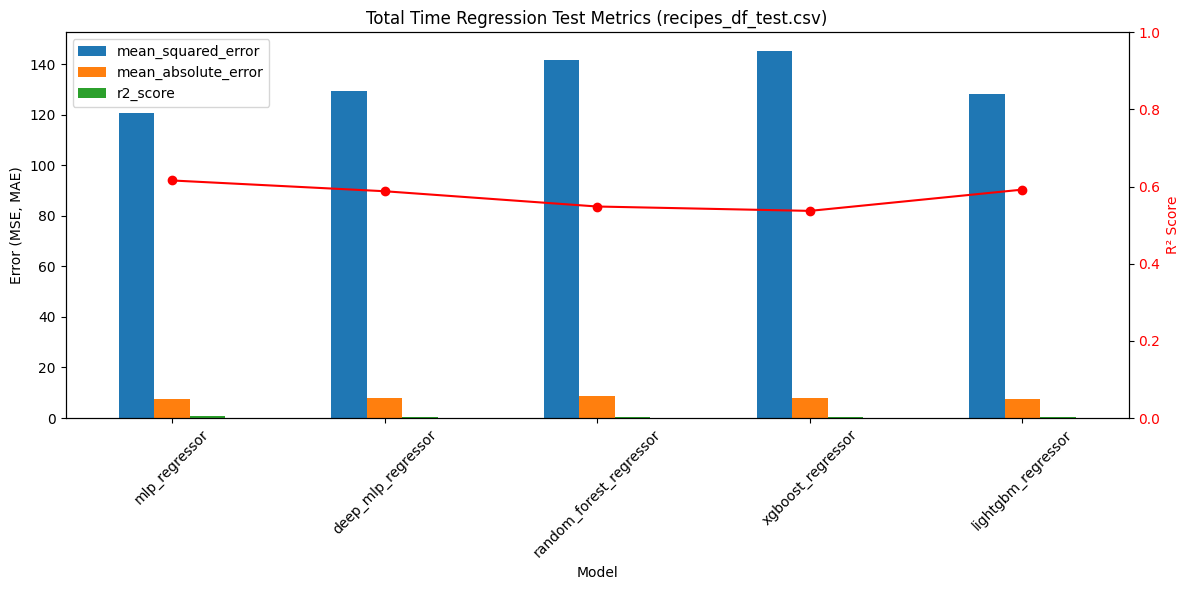

In [ ]:
# --- 4. Evaluation on External Dataset (Total Time Regression) ---
import matplotlib.pyplot as plt

# --- Preprocess Test Set ---
test_results_path = os.path.join(RESULTS_DIR, "total_time_test_results.csv")

if os.path.exists(test_results_path):
    print(f"Test results already exist at {test_results_path}, loading from file.")
    test_results_df = pd.read_csv(test_results_path)
    # Reload test data for detailed analysis later
    test_df = load_csv('recipes_df_test.csv')
    test_df = test_df.dropna(subset=['embeddings_reg', 'times'])
    test_df['time_vec'] = test_df['times'].apply(parse_time)
    test_df['total_time'] = test_df['time_vec'].apply(lambda x: sum(x) if None not in x else None)
    valid_test_df = test_df[test_df['total_time'].notnull()]
    X_test, y_test_list = prepare_embeddings_data(valid_test_df, target_column='total_time', embedding_column='embeddings_reg')
    y_test = np.array(y_test_list).flatten()
else:
    print("Evaluating models on external recipes_df_test.csv dataset for total time prediction...")
    test_df = load_csv('recipes_df_test.csv')
    test_df = test_df.dropna(subset=['embeddings_reg', 'times'])
    test_df['time_vec'] = test_df['times'].apply(parse_time)
    test_df['total_time'] = test_df['time_vec'].apply(lambda x: sum(x) if None not in x else None)
    valid_test_df = test_df[test_df['total_time'].notnull()]
    X_test, y_test_list = prepare_embeddings_data(valid_test_df, target_column='total_time', embedding_column='embeddings_reg')
    y_test = np.array(y_test_list).flatten()

    # --- Evaluate all models ---
    test_results = []
    for model_cfg in model_configs:
        model_name = model_cfg['name']
        # Load trained model
        model = load_model(model_cfg['class'], model_name, model_cfg['params'], path_start='total_time_train')
        is_torch_model = hasattr(model, 'parameters')
        pipeline = SimplePredictor(
            model=model,
            task_type='regression'
        )
        y_pred = pipeline.predict(X_test)

        # Collect metrics
        result = {}
        for metric in metrics:
            metric_key = metric.__name__
            result[metric_key] = metric(y_test, y_pred)
        result['model'] = model_name
        test_results.append(result)

    # Save test results
    test_results_df = pd.DataFrame(test_results)
    test_results_df.to_csv(test_results_path, index=False)
    print("Test results saved to", test_results_path)

# --- Visualize Results ---
fig, ax1 = plt.subplots(figsize=(12, 6))
print(test_results_df.columns)
test_results_df.set_index('model')[['mean_squared_error', 'mean_absolute_error', 'r2_score']].plot(kind='bar', ax=ax1)
ax1.set_ylabel('Error (MSE, MAE)')
ax1.set_xlabel('Model')
ax1.set_title("Total Time Regression Test Metrics (recipes_df_test.csv)")
ax1.tick_params(axis='x', rotation=45)

# Plot R2 score on a secondary y-axis
ax2 = ax1.twinx()
test_results_df.set_index('model')['r2_score'].plot(kind='line', marker='o', color='r', ax=ax2)
ax2.set_ylabel('R² Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, max(1.0, test_results_df['r2_score'].max() * 1.1))

fig.tight_layout()

test_results_df

Evaluating models on external recipes_df_test.csv dataset for total time prediction...
Test results saved to results/total_time_test_results2.csv
Index(['mean_squared_error', 'mean_absolute_error', 'r2_score', 'model'], dtype='object')


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,mean_squared_error,mean_absolute_error,r2_score,model
0,369.770203,14.114606,0.200436,mlp_regressor
1,337.138947,13.332788,0.270995,deep_mlp_regressor
2,337.953475,13.910440,0.269234,random_forest_regressor
3,382.800476,14.113450,0.172260,xgboost_regressor
4,327.727062,13.068623,0.291347,lightgbm_regressor


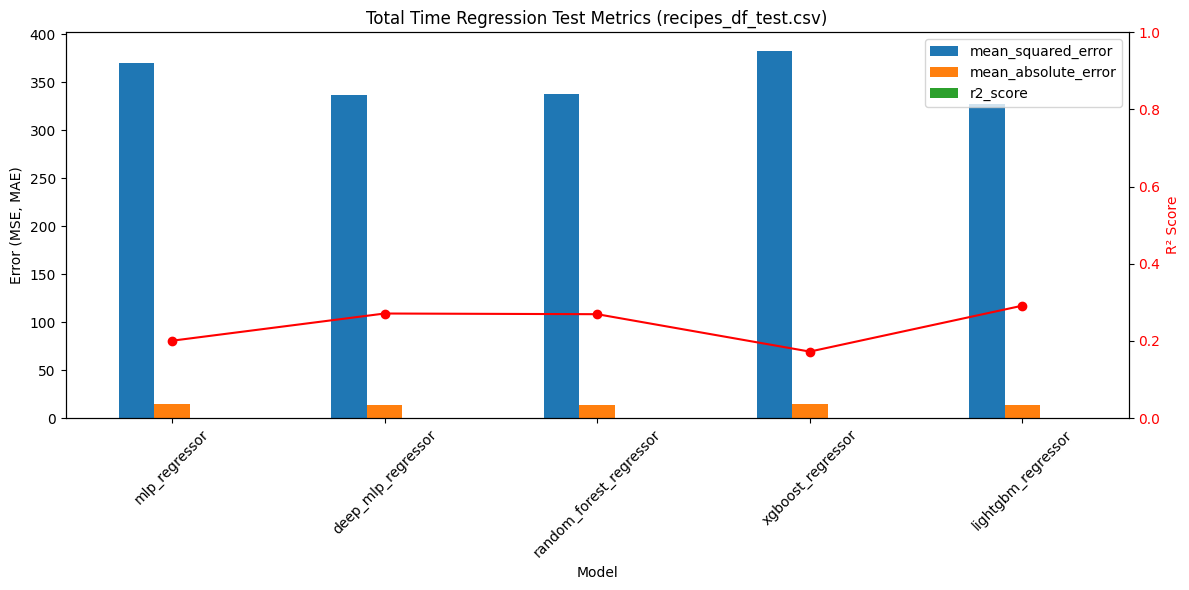

In [ ]:
# --- 4. Evaluation on External Dataset (Total Time Regression) ---
import matplotlib.pyplot as plt

# --- Preprocess Test Set ---
test_results_path = os.path.join(RESULTS_DIR, "total_time_test_results2.csv")

if os.path.exists(test_results_path):
    print(f"Test results already exist at {test_results_path}, loading from file.")
    test_results_df = pd.read_csv(test_results_path)
    # Reload test data for detailed analysis later
    test_df = load_csv('recipes_df_test.csv')
    test_df = test_df.dropna(subset=['embeddings_reg', 'times'])
    test_df['time_vec'] = test_df['times'].apply(parse_time)
    test_df['total_time'] = test_df['time_vec'].apply(lambda x: sum(x) if None not in x else None)
    valid_test_df = test_df[test_df['total_time'].notnull()]
    X_test, y_test_list = prepare_embeddings_data(valid_test_df, target_column='total_time', embedding_column='embeddings_reg')
    y_test = np.array(y_test_list).flatten()
else:
    print("Evaluating models on external recipes_df_test.csv dataset for total time prediction...")
    test_df = load_csv('recipes_df_test_bis.csv')
    test_df = test_df.dropna(subset=['embeddings_reg', 'times'])
    test_df['time_vec'] = test_df['times'].apply(parse_time)
    test_df['total_time'] = test_df['time_vec'].apply(lambda x: sum(x) if None not in x else None)
    valid_test_df = test_df[test_df['total_time'].notnull()]
    X_test, y_test_list = prepare_embeddings_data(valid_test_df, target_column='total_time', embedding_column='embeddings_reg')
    y_test = np.array(y_test_list).flatten()

    # --- Evaluate all models ---
    test_results = []
    for model_cfg in model_configs:
        model_name = model_cfg['name']
        # Load trained model
        model = load_model(model_cfg['class'], model_name, model_cfg['params'], path_start='total_time_train')
        is_torch_model = hasattr(model, 'parameters')
        pipeline = SimplePredictor(
            model=model,
            task_type='regression'
        )
        # Inference
        y_pred = pipeline.predict(X_test)

        # Collect metrics
        result = {}
        for metric in metrics:
            metric_key = metric.__name__
            result[metric_key] = metric(y_test, y_pred)
        result['model'] = model_name
        test_results.append(result)

    # Save test results
    test_results_df = pd.DataFrame(test_results)
    test_results_df.to_csv(test_results_path, index=False)
    print("Test results saved to", test_results_path)

# --- Visualize Results ---
fig, ax1 = plt.subplots(figsize=(12, 6))
print(test_results_df.columns)
test_results_df.set_index('model')[['mean_squared_error', 'mean_absolute_error', 'r2_score']].plot(kind='bar', ax=ax1)
ax1.set_ylabel('Error (MSE, MAE)')
ax1.set_xlabel('Model')
ax1.set_title("Total Time Regression Test Metrics (recipes_df_test.csv)")
ax1.tick_params(axis='x', rotation=45)

# Plot R2 score on a secondary y-axis
ax2 = ax1.twinx()
test_results_df.set_index('model')['r2_score'].plot(kind='line', marker='o', color='r', ax=ax2)
ax2.set_ylabel('R² Score', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(0, max(1.0, test_results_df['r2_score'].max() * 1.1))

fig.tight_layout()

test_results_df


--- Detailed Analysis for Best Model: lightgbm_regressor ---


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


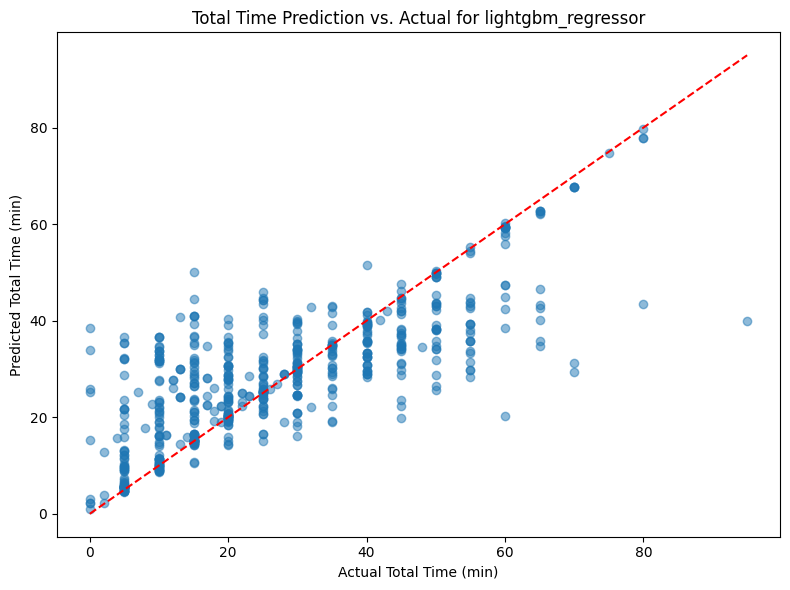

Mean Squared Error: 128.02
Mean Absolute Error: 7.61
R² Score: 0.592


In [43]:
# --- Detailed Analysis for Best Model (Total Time Regression) ---
# Find the best model based on R2 score
best_model_name = test_results_df.loc[test_results_df['r2_score'].idxmax()]['model']
print(f"\n--- Detailed Analysis for Best Model: {best_model_name} ---")

# Get predictions for the best model again
best_model_cfg = next(cfg for cfg in model_configs if cfg['name'] == best_model_name)
model = load_model(best_model_cfg['class'], best_model_name, best_model_cfg['params'], path_start='total_time_train')
test_df = load_csv('recipes_df_test.csv')
test_df = test_df.dropna(subset=['embeddings_reg', 'times'])
test_df['time_vec'] = test_df['times'].apply(parse_time)
test_df['total_time'] = test_df['time_vec'].apply(lambda x: sum(x) if None not in x else None)
valid_test_df = test_df[test_df['total_time'].notnull()]
X_test, y_test_list = prepare_embeddings_data(valid_test_df, target_column='total_time', embedding_column='embeddings_reg')
y_test = np.array(y_test_list).flatten()

if hasattr(model, 'parameters'):
    pipeline = GeneralPipeline(
        model=model,
        loss_fn='MSELoss',
        optimizer_cls=torch.optim.Adam,
        optimizer_params={'lr': 1e-4, 'weight_decay': 1e-4},
        metrics=metrics,
        task_type='regression',
        device='cpu',
        epochs=300,
        batch_size=32,
        early_stopping=15,
        use_class_weights=False
    )
else:
    pipeline = GeneralPipelineSklearn(model=model, task_type='regression')

y_pred_best = pipeline.predict(X_test)

# Plot regression results for total time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Total Time (min)")
plt.ylabel("Predicted Total Time (min)")
plt.title(f"Total Time Prediction vs. Actual for {best_model_name}")
plt.tight_layout()
plt.show()

# Print metrics for best model
mse = mean_squared_error(y_test, y_pred_best)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.3f}")

### Time Classification

In [51]:
time_df = load_csv('recipes_df.csv')
def parse_time(row):
    import ast
    try:
        d = ast.literal_eval(row) if isinstance(row, str) else row
        if not isinstance(d, dict):
            return [None, None]
        prep = d.get('Preparation', '0').replace('No Time','0').replace('mins','').replace('min','').strip()
        cook = d.get('Cooking', '0').replace('No Time','0').replace('mins','').replace('min','').strip()
        try:
            prep = int(round(float(prep)))
        except Exception:
            prep = 0
        try:
            cook = int(round(float(cook)))
        except Exception:
            cook = 0
        return [prep, cook]
    except Exception:
        return [None, None]
time_df['time_vec'] = time_df['times'].apply(parse_time)
time_df['total_time'] = time_df['time_vec'].apply(lambda x: sum(x) if None not in x else None)
valid_time_df = time_df[time_df['time_vec'].apply(lambda x: None not in x) & time_df['total_time'].notnull()]

# Bin total_time: <5, 5, 10, 15, ..., 55, >60
def time_bin(t):
    if t < 15:
        return 0
    elif t < 30:
        return 1
    elif t < 60:
        return 2
    else:
        return 3

valid_time_df['total_time_bin'] = valid_time_df['total_time'].apply(time_bin)

X_timec, y_timec = prepare_embeddings_data(
    valid_time_df, 
    target_column='total_time_bin', 
    embedding_column='embeddings_class'
)
X_train_timec, X_val_timec, _, y_train_timec, y_val_timec, _ = train_val_test_split(
    X_timec, 
    np.array(y_timec).reshape(-1, 1), 
    val_size=0.15, 
    test_size=0, 
    stratify=np.array(y_timec).reshape(-1, 1)
)
input_dim = X_train_timec.shape[1]
output_dim = 1  # For classification, output is 1D

# Print class distribution for sanity check
import numpy as np
unique, counts = np.unique(y_train_timec, return_counts=True)
print("Train set total_time_bin class distribution:")
for cls, cnt in zip(unique, counts):
    print(f"Class {cls}: {cnt}")

Train set total_time_bin class distribution:
Class 0: 235
Class 1: 387
Class 2: 495
Class 3: 128


In [52]:
num_classes = len(np.unique(y_train_timec))
model_names = [
    'mlp_classifier', 'deep_mlp_classifier', 'random_forest_classifier', 'xgboost_classifier', 'lightgbm_classifier'
]
model_configs = [
    {
        'name': name,
        'class': MODEL_REGISTRY[name],
        'params': {'input_dim': input_dim, 'num_classes': num_classes} if 'mlp' in name else {}
    }
    for name in model_names
]
metrics = [METRIC_REGISTRY['f1'], METRIC_REGISTRY['recall'], METRIC_REGISTRY['precision'], METRIC_REGISTRY['accuracy']]

In [ ]:
best_aug_name = 'borderline_smote'
best_augmentation = AUGMENTATION_REGISTRY[best_aug_name]
for model_cfg in model_configs:
    model_name = model_cfg['name']
    metrics_path = os.path.join(RESULTS_DIR, f"total_time_class_train/{model_name}_train_metrics.csv")
    if os.path.exists(metrics_path):
        print(f"Metrics already exist for {model_name}, skipping training.")
        continue
    model = model_cfg['class'](**model_cfg['params'])
    is_torch_model = hasattr(model, 'parameters')
    if is_torch_model:
        pipeline = GeneralPipeline(
            model=model,
            loss_fn='CrossEntropyLoss',
            optimizer_cls=torch.optim.Adam,
            optimizer_params={'lr': 1e-4, 'weight_decay': 5e-4},
            metrics=metrics,
            task_type='classification',
            device='cpu',
            epochs=400,
            batch_size=32,
            early_stopping=40,
            use_class_weights=False, 
            dropout=0.3, 
            augmentations=best_augmentation,
            max_factor=1.5,
        )
        history = pipeline.fit(X_timec, y_timec)
    else:
        pipeline = GeneralPipelineSklearn(
            model=model,
            metrics=metrics,
            task_type='classification', 
            class_weight=None, 
            augmentations=best_augmentation,
            max_factor=1.5,
        )
        history = pipeline.fit(X_timec, y_timec)
    save_model(model, model_name, path_start='total_time_class_train')
    save_metrics(history, model_name, 'train', path_start='total_time_class_train')

Starting 5-fold cross-validation with weight averaging ensemble
Starting 5-fold cross-validation with weight averaging ensemble...
Training fold 1/5
Epoch 1/400 - Train Loss: 1.3834, Val Loss: 1.3722, F1: 0.1418
Epoch 2/400 - Train Loss: 1.3766, Val Loss: 1.3572, F1: 0.1418
Epoch 3/400 - Train Loss: 1.3711, Val Loss: 1.3483, F1: 0.1418
Epoch 4/400 - Train Loss: 1.3636, Val Loss: 1.3360, F1: 0.1998
Epoch 5/400 - Train Loss: 1.3521, Val Loss: 1.3200, F1: 0.3129
Epoch 6/400 - Train Loss: 1.3404, Val Loss: 1.3023, F1: 0.3104
Epoch 7/400 - Train Loss: 1.3153, Val Loss: 1.2792, F1: 0.3117
Epoch 8/400 - Train Loss: 1.2917, Val Loss: 1.2542, F1: 0.3107
Epoch 9/400 - Train Loss: 1.2672, Val Loss: 1.2282, F1: 0.3076
Epoch 10/400 - Train Loss: 1.2397, Val Loss: 1.2099, F1: 0.3273
Epoch 11/400 - Train Loss: 1.2231, Val Loss: 1.1965, F1: 0.3713
Epoch 12/400 - Train Loss: 1.2010, Val Loss: 1.1794, F1: 0.3804
Epoch 13/400 - Train Loss: 1.1866, Val Loss: 1.1712, F1: 0.4297
Epoch 14/400 - Train Loss: 1

/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 1 f1_score: 0.6195
Training fold 2/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195835
[LightGBM] [Info] Number of data points in the train set: 1360, number of used features: 768
[LightGBM] [Info] Start training from score -1.478668
[LightGBM] [Info] Start training from score -1.428343
[LightGBM] [Info] Start training from score -1.165507
[LightGBM] [Info] Start training from score -1.511458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 2 f1_score: 0.5730
Training fold 3/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195837
[LightGBM] [Info] Number of data points in the train set: 1375, number of used features: 768
[LightGBM] [Info] Start training from score -1.489637
[LightGBM] [Info] Start training from score -1.427116
[LightGBM] [Info] Start training from score -1.169425
[LightGBM] [Info] Start training from score -1.496109


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 3 f1_score: 0.5281
Training fold 4/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195833
[LightGBM] [Info] Number of data points in the train set: 1361, number of used features: 768
[LightGBM] [Info] Start training from score -1.479403
[LightGBM] [Info] Start training from score -1.429078
[LightGBM] [Info] Start training from score -1.178104
[LightGBM] [Info] Start training from score -1.492390
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 4 f1_score: 0.5487
Training fold 5/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195837
[LightGBM] [Info] Number of data points in the train set: 1358, number of used features: 768
[LightGBM] [Info] Start training from score -1.477196
[LightGBM] [Info] Start training from score -1.420755
[LightGBM] [Info] Start training from score -1.178287
[LightGBM] [Info] Start training from score -1.503341


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Fold 5 f1_score: 0.5174

CROSS-VALIDATION RESULTS
🎯 F1_SCORE       : 0.5573 ± 0.0364

accuracy_score : 0.6109 ± 0.0252
precision_score: 0.5905 ± 0.0418
recall_score   : 0.5452 ± 0.0306


Training final model on full dataset...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195839
[LightGBM] [Info] Number of data points in the train set: 1718, number of used features: 768
[LightGBM] [Info] Start training from score -1.487911
[LightGBM] [Info] Start training from score -1.420638
[LightGBM] [Info] Start training from score -1.170395
[LightGBM] [Info] Start training from score -1.503495
✅ Final model trained successfully on full dataset!


## 4.Evaluation

Test set total_time_bin class distribution:
Class 0: 165
Class 1: 202
Class 2: 218
Class 3: 41
Test results saved to results/total_time_class_test_results.csv


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


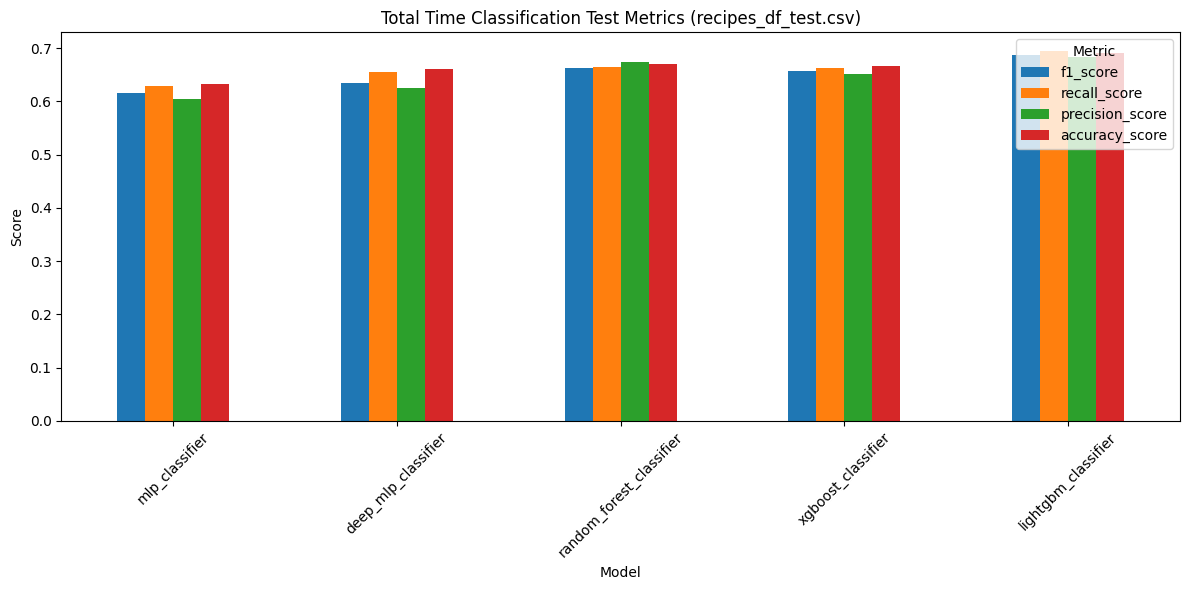

,f1_score,recall_score,precision_score,accuracy_score,model
0,0.614913,0.628802,0.604718,0.632588,mlp_classifier
1,0.633555,0.655616,0.625711,0.659744,deep_mlp_classifier
2,0.663031,0.664859,0.673761,0.670927,random_forest_classifier
3,0.656318,0.662777,0.651548,0.666134,xgboost_classifier
4,0.687402,0.694730,0.683968,0.690096,lightgbm_classifier


In [ ]:
test_df = load_csv('recipes_df_test.csv')
test_df = test_df.dropna(subset=['embeddings_class', 'times'])

def parse_time(row):
    import ast
    try:
        d = ast.literal_eval(row) if isinstance(row, str) else row
        if not isinstance(d, dict):
            return [None, None]
        prep = d.get('Preparation', '0').replace('No Time','0').replace('mins','').replace('min','').strip()
        cook = d.get('Cooking', '0').replace('No Time','0').replace('mins','').replace('min','').strip()
        try:
            prep = int(round(float(prep)))
        except Exception:
            prep = 0
        try:
            cook = int(round(float(cook)))
        except Exception:
            cook = 0
        return [prep, cook]
    except Exception:
        return [None, None]

test_df['time_vec'] = test_df['times'].apply(parse_time)
test_df['total_time'] = test_df['time_vec'].apply(lambda x: sum(x) if None not in x else None)

# Bin total_time: <5, 5, 10, ..., 55, >60
def time_bin(t):
    if t < 15:
        return 0
    elif t < 30:
        return 1
    elif t < 60:
        return 2
    else:
        return 3

valid_test_df = test_df[test_df['total_time'].notnull()]
valid_test_df['total_time_bin'] = valid_test_df['total_time'].apply(time_bin)

X_test, y_test = prepare_embeddings_data(
    valid_test_df,
    target_column='total_time_bin',
    embedding_column='embeddings_class'
)
y_test = np.array(y_test).flatten()
unique, counts = np.unique(y_test, return_counts=True)
class_dist = dict(zip(unique, counts))
print("Test set total_time_bin class distribution:")
for cls, cnt in class_dist.items():
    print(f"Class {cls}: {cnt}")

# Evaluate all models
test_results = []
for model_cfg in model_configs:
    model_name = model_cfg['name']
    # Load trained model
    model = load_model(model_cfg['class'], model_name, model_cfg['params'], path_start='total_time_class_train')
    is_torch_model = hasattr(model, 'parameters')
    pipeline = SimplePredictor(
        model=model,
        task_type='classification'
    )
    # Inference
    y_pred = pipeline.predict(X_test)
    # Collect metrics
    result = {}
    for metric in metrics:
        metric_key = getattr(metric, 'name', None) or getattr(metric, '__name__', None) or str(metric)
        result[metric_key] = metric(y_test, y_pred)
    result['model'] = model_name
    test_results.append(result)

# Save test results
test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv(os.path.join(RESULTS_DIR, "total_time_class_test_results.csv"), index=False)
print("Test results saved to", os.path.join(RESULTS_DIR, "total_time_class_test_results.csv"))

# Plot grouped bar chart of metrics for all models
import matplotlib.pyplot as plt
test_results_df.set_index('model').plot(kind='bar', figsize=(12,6))
plt.title("Total Time Classification Test Metrics (recipes_df_test.csv)")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

test_results_df

Test set total_time_bin class distribution:
Class 0: 85
Class 1: 127
Class 2: 297
Class 3: 105
Test results saved to results/total_time_class_test_results_b.csv


/opt/homebrew/Caskroom/miniconda/base/envs/projects/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


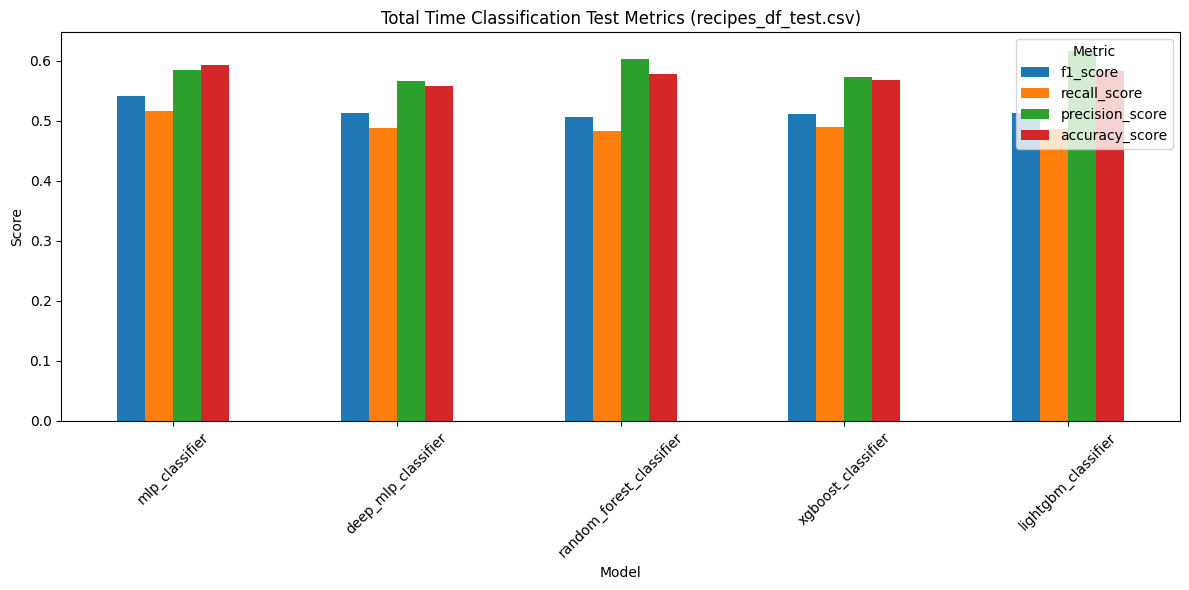

,f1_score,recall_score,precision_score,accuracy_score,model
0,0.541311,0.517140,0.585420,0.592834,mlp_classifier
1,0.513332,0.487458,0.565627,0.558632,deep_mlp_classifier
2,0.506020,0.483700,0.603893,0.578176,random_forest_classifier
3,0.512269,0.489719,0.573584,0.568404,xgboost_classifier
4,0.512435,0.485973,0.616725,0.583062,lightgbm_classifier


In [ ]:
test_df = load_csv('recipes_df_test_bis.csv')
test_df = test_df.dropna(subset=['embeddings_class', 'times'])

def parse_time(row):
    import ast
    try:
        d = ast.literal_eval(row) if isinstance(row, str) else row
        if not isinstance(d, dict):
            return [None, None]
        prep = d.get('Preparation', '0').replace('No Time','0').replace('mins','').replace('min','').strip()
        cook = d.get('Cooking', '0').replace('No Time','0').replace('mins','').replace('min','').strip()
        try:
            prep = int(round(float(prep)))
        except Exception:
            prep = 0
        try:
            cook = int(round(float(cook)))
        except Exception:
            cook = 0
        return [prep, cook]
    except Exception:
        return [None, None]

test_df['time_vec'] = test_df['times'].apply(parse_time)
test_df['total_time'] = test_df['time_vec'].apply(lambda x: sum(x) if None not in x else None)

# Bin total_time: <5, 5, 10, ..., 55, >60
def time_bin(t):
    if t < 15:
        return 0
    elif t < 30:
        return 1
    elif t < 60:
        return 2
    else:
        return 3

valid_test_df = test_df[test_df['total_time'].notnull()]
valid_test_df['total_time_bin'] = valid_test_df['total_time'].apply(time_bin)

X_test, y_test = prepare_embeddings_data(
    valid_test_df,
    target_column='total_time_bin',
    embedding_column='embeddings_class'
)
y_test = np.array(y_test).flatten()
unique, counts = np.unique(y_test, return_counts=True)
class_dist = dict(zip(unique, counts))
print("Test set total_time_bin class distribution:")
for cls, cnt in class_dist.items():
    print(f"Class {cls}: {cnt}")

# Evaluate all models
test_results = []
for model_cfg in model_configs:
    model_name = model_cfg['name']
    # Load trained model
    model = load_model(model_cfg['class'], model_name, model_cfg['params'], path_start='total_time_class_train')
    is_torch_model = hasattr(model, 'parameters')
    pipeline = SimplePredictor(
        model=model,
        task_type='classification'
    )
    # Inference
    y_pred = pipeline.predict(X_test)
    # Collect metrics
    result = {}
    for metric in metrics:
        metric_key = getattr(metric, 'name', None) or getattr(metric, '__name__', None) or str(metric)
        result[metric_key] = metric(y_test, y_pred)
    result['model'] = model_name
    test_results.append(result)

# Save test results
test_results_df = pd.DataFrame(test_results)
test_results_df.to_csv(os.path.join(RESULTS_DIR, "total_time_class_test_results_b.csv"), index=False)
print("Test results saved to", os.path.join(RESULTS_DIR, "total_time_class_test_results_b.csv"))

# Plot grouped bar chart of metrics for all models
import matplotlib.pyplot as plt
test_results_df.set_index('model').plot(kind='bar', figsize=(12,6))
plt.title("Total Time Classification Test Metrics (recipes_df_test.csv)")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

test_results_df


## Conclusion
This notebook provides a full benchmarking workflow for recipe classification/regression, including augmentation selection, model comparison, and external validation. All results are reproducible and ready for further analysis.
